## Performing DA and Control Simulation Experiments (CSE)

##### Loading Python Modules:

In [1]:
import numpy as np
import pickle
import random
import sys
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from class_Lorenz63 import run_RK4
from class_state_vec import state_vector
from class_obs import obs_da
from class_da_sys import da_system
from class_cse_checks import cse

#### Defining lorenz63 model:

In [2]:
sigma = 10.0       # Parameter sigma
rho   = 28.0       # Parameter rho
beta  = 8.0 / 3.0  # Parameter beta

def lorenz63(state, t):
        """
        Calculates the derivatives for the Lorenz63 system.
        
        Parameters:
        state: vector [x, y, z] representing the current state.
        t: current time (not used in Lorenz63 but included for compatibility).
        
        Returns:
        A vector of derivatives [dx/dt, dy/dt, dz/dt].
        """
        x, y, z = state  # Unpack the state vector
        dx = sigma * (y - x)              # Equation for dx/dt
        dy = x * (rho - z) - y            # Equation for dy/dt
        dz = x * y - beta * z             # Equation for dz/dt
        return np.array([dx, dy, dz])     # Return the derivative vector

#### Load the DA system object:

In [3]:
#-----------------------------------------------------------
# Reading da system object:
#-----------------------------------------------------------
name   = 'x_analysis'
infile = name + '_init.pkl'
das    = da_system()
das    = das.load(infile)
#print(das)

#### Initialize the Ensemble:

In [4]:
#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
xa = das.x0
Xa = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

print('Ensemble dimension: ', das.edim)
print('Initial bias: ', das.ens_bias_init)
print('Initial standard deviation: ', das.ens_sigma_init)
print('xa: ', xa)
print('Xa: ', Xa)


Ensemble dimension:  3
Initial bias:  0
Initial standard deviation:  1.4142135623730951
xa:  [ 8.20747939 10.0860429  23.86324441]
Xa:  [[ 8.84809326  9.35790455  6.41644037]
 [12.87474221  8.01874806  9.36463844]
 [25.42312345 22.95083842 23.21577135]]


#### Get the Nature Run Trajectory:

In [5]:
sv       = das.getStateVector()
x_nature = sv.getTrajectory()

print('x_nature: ', x_nature)

x_nature:  [[ 8.20747939  8.39809589  8.59182394 ... -4.9986383  -4.69976127
  -4.4329259 ]
 [10.0860429  10.31905559 10.5401999  ... -1.85089003 -1.87383032
  -1.92237055]
 [23.86324441 24.07111655 24.31175358 ... 27.47111935 26.83733919
  26.21667603]]


#### Get the observations via the obs_da object:

In [6]:
obs   = das.getObsData()
y_obs = obs.getVal()
y_pos = obs.getPos()
y_err = obs.getErr()

#### Initialize timesteps:

In [7]:
#-----------------------------------------------------------
# Initialize the timesteps:
#-----------------------------------------------------------
t_nature  = sv.getTimes()
acyc_step = das.acyc_step
dtau      = das.dtau
dt_output = das.dt 
fcst_step = das.fcst_dt
fcst_dt   = das.fcst_dt
maxit     = das.maxit
xdim      = das.xdim
ydim      = das.ydim

#print('t_nature: ', t_nature)

#### Choose DA method:

In [8]:
#-----------------------------------------------------------
# Choose DA method:
#-----------------------------------------------------------
method = das.getMethod()
print('Method: ', method)

Method:  EnKF


#### Using same historical data for DA that was used for Qiwen et al., 2022:

In [9]:
#-----------------------------------------------------------
# DO NOT CHANGE THE FOLLOWING LINES:
#-----------------------------------------------------------

''' 

DO NOT CHANGE THE FOLLOWING LINES!!

'''

with open("change_region_time.txt", "rb") as fp:   # Unpickling
    change_region_time = pickle.load(fp)

change_region_time[1]-change_region_time[0]

#########
p = 0
slected_change_region_time = []

for i in range(len(change_region_time)):
    if change_region_time[i] < 500:
        continue
        
    #if change_region_time[i]-change_region_time[i-1] > 337:
    if change_region_time[i]-change_region_time[i-1] > 385:
        slected_change_region_time.append(change_region_time[i])
        #plt.plot(i, change_region_time[i]-change_region_time[i-1], linestyle = 'None', marker = '.')
        p = p + 1
        

#########
t_start_series =[]
for point in slected_change_region_time:
    if point%1 ==0:
        t_start_series.append(point)
        if len(t_start_series)>99:
            break


# Creating evo_history variable:
for t_start in t_start_series[40:41]:
    multiple_number = 4 #this is the  parameter before To in the paper 
    position = int(np.ceil(75.1*multiple_number))
    x_original = x_nature[:,(t_start - position)-(t_start - position)%acyc_step]
    obs_original = y_obs[:,(t_start - position)-(t_start - position)%acyc_step]
    experiment_step = 1000
    evo_history = np.zeros((3,experiment_step*acyc_step+1))
    no_ch_bkp = np.zeros((experiment_step, das.xdim, das.edim))   # change the last dimension
    evo_history[:,0] = x_original


# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, evo_history[:,0] , 0.01, 80)

# Run the solver:
no_control = solver.run(evo_history[:,0],np.arange(0,80,0.01),np.arange(0,80,0.01))

#### Nature Run + Observations:

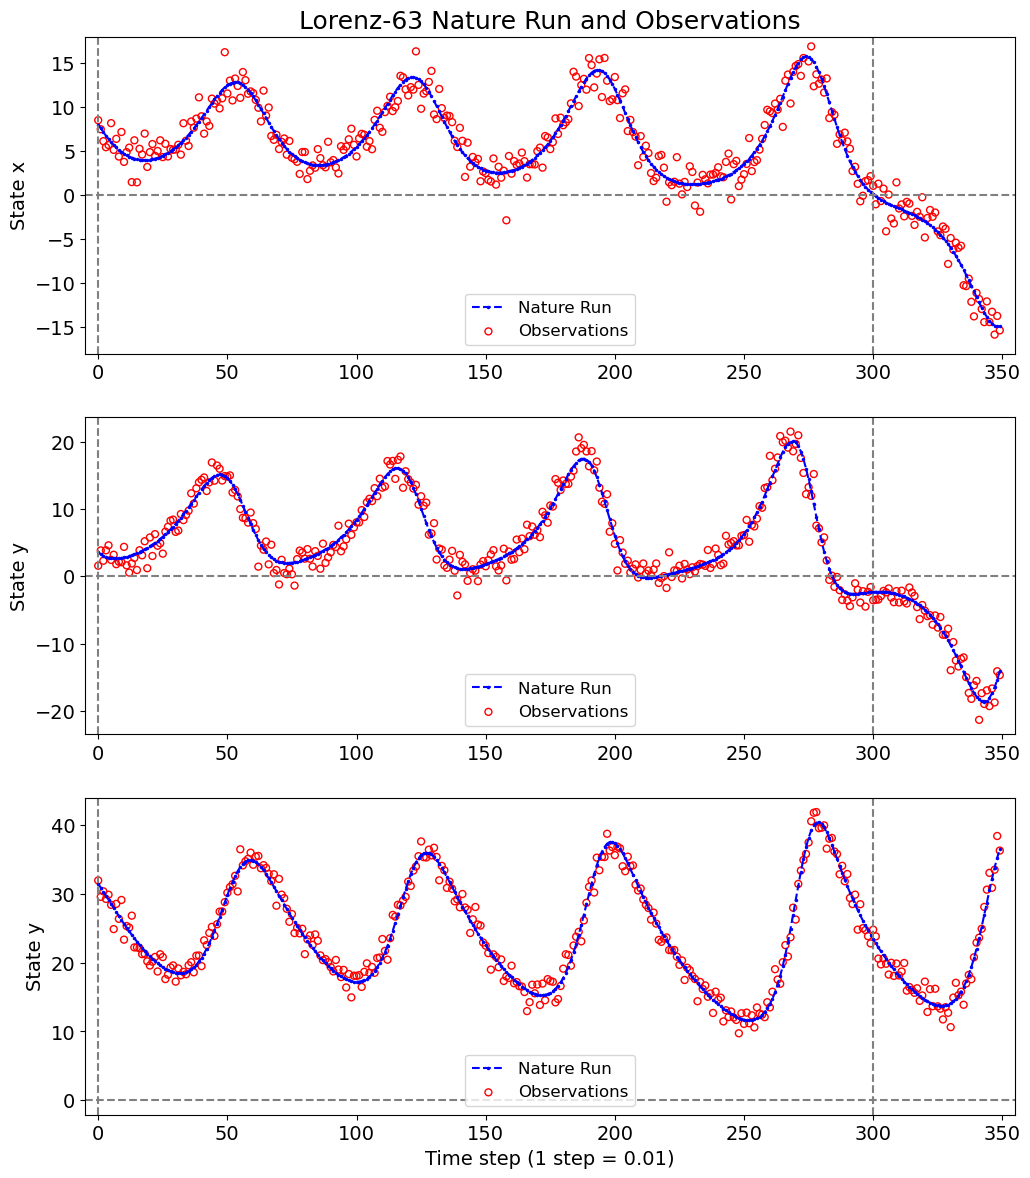

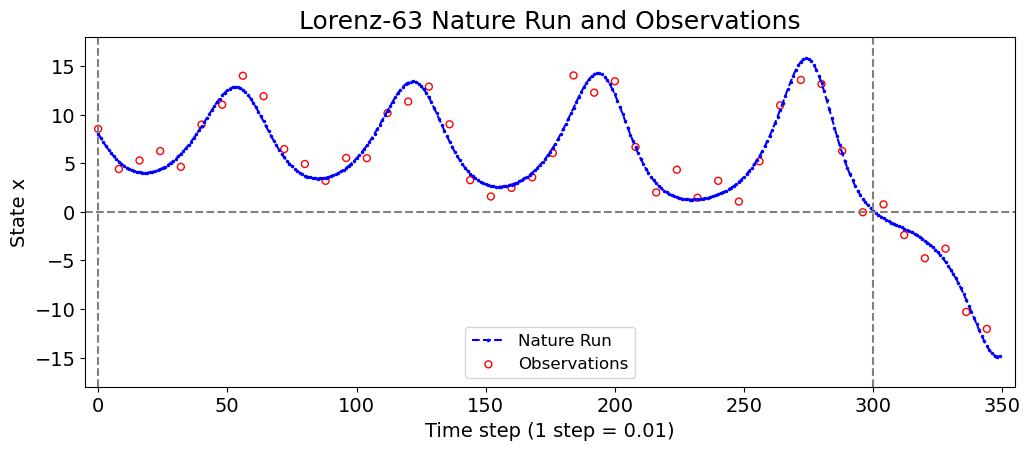

In [191]:
#
# Creating some nice plots:
#
fig = plt.figure(figsize = (12,14))
ax  = fig.add_subplot(311)
plt.plot(x_nature[0,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(350),y_obs[0,105768:105768+350], marker='o', s = 25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
#plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State x', fontsize = 14)
plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
#
ax  = fig.add_subplot(312)
plt.plot(x_nature[1,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(350),y_obs[1,105768:105768+350], marker='o', s = 25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
#plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State y', fontsize = 14)
#plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
#
ax  = fig.add_subplot(313)
plt.plot(x_nature[2,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(350),y_obs[2,105768:105768+350], marker='o', s = 25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State y', fontsize = 14)
#plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
fig.savefig('Lorenz63_nature_run_observations_xyz', bbox_inches = 'tight')

# Plotting observations every 8th time step:
fig = plt.figure(figsize = (12,10))
ax  = fig.add_subplot(211)
plt.plot(x_nature[0,105768:105768+350], linestyle = 'dashed',marker='.', markersize = 3, color = 'blue', label="Nature Run")
plt.scatter(np.arange(0, 350, 8), y_obs[0, 105768:105768+350:8], marker='o', s=25, facecolors='none', edgecolors='red', label="Observations")
plt.axhline(y=0, linestyle='dashed', color = 'grey')
plt.axvline(x=0, linestyle='dashed', color = 'grey')
plt.axvline(x=300, linestyle='dashed', color = 'grey')
plt.xlabel('Time step (1 step = 0.01)', fontsize = 14)
plt.ylabel('State x', fontsize = 14)
plt.title('Lorenz-63 Nature Run and Observations', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
plt.xlim(-5,350+5)
ax.legend(fontsize=12)
fig.savefig('Lorenz63_nature_run_observations_NoControl.png', bbox_inches = 'tight')


#### Running Control Simulation Experiments (CSE) with 1000 iterations:

 * * * Starting the Control Simulation Experiment * * *
 * * * DA update using the observations at time t = 0 * * *
       We choose t = 105768 as the starting time for the control simulation experiment.

 * * * STEP 1: DA update using the observations at time t = 0 * * *
t_index:  0
CSE System Step 1
Method:  EnKF
Xf: [[ 8.65678354  9.16659483  6.22513065]
 [ 6.35741087  1.50141672  2.8473071 ]
 [33.03161673 30.55933171 30.82426463]]
Xa: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]

 * * * STEP 2: RUN ENSEMBLE FORECAST * * *
CSE System Step 2
Position: 301
initial condition forecast: [[ 8.71629577  9.18477686  7.17368814]
 [ 3.69818037  1.49678186  2.20357325]
 [31.64477755 30.55962799 30.62875543]]
initial condition xf_4d[:,0,:]: [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]

 * * * STEP 3: CHECKING REGIME SHIFT * * *
CSE System Step 3
Regim

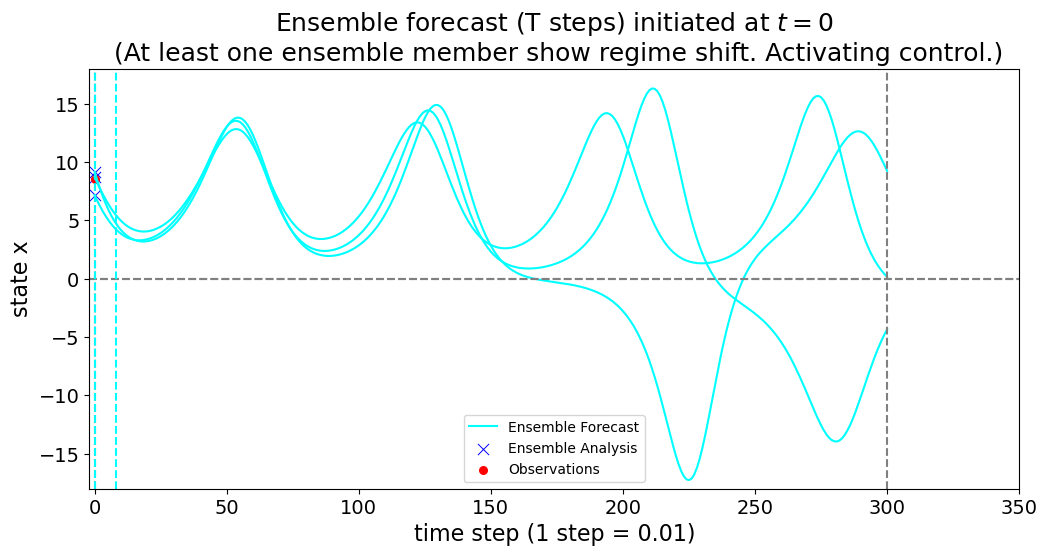

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 8.71629577  3.69818037 31.64477755]
 [ 9.18477686  1.49678186 30.55962799]
 [ 7.17368814  2.20357325 30.62875543]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[-3.74989544e-02  1.76208053e-01  8.68593724e-02]
 [-1.80451008e-02  1.71606645e-01  1.01121381e-01]
 [-4.86056232e-04  1.64624540e-01  1.13571671e-01]
 [ 1.49114782e-02  1.56126667e-01  1.24105244e-01]
 [ 2.80827681e-02  1.46886119e-01  1.32799947e-01]
 [ 3.91708715e-02  1.37459278e-01  1.39894924e-01]
 [ 4.83568381e-02  1.28251247e-01  1.45647636e-01]
 [ 5.58109238e-02  1.19587085e-01  1.50279971e-01]
 [ 6.17303353e-02  1.11682823e-01  1.54001015e-01]
 [ 6.63232942e-02  1.04655728e-01  1.56998087e-01]
 [ 6.97998003e-02  9.85344683e-02  1.59433204e-01]
 [ 7.23677161e-02  9.32675929e-02  1.61443705e-01]
 

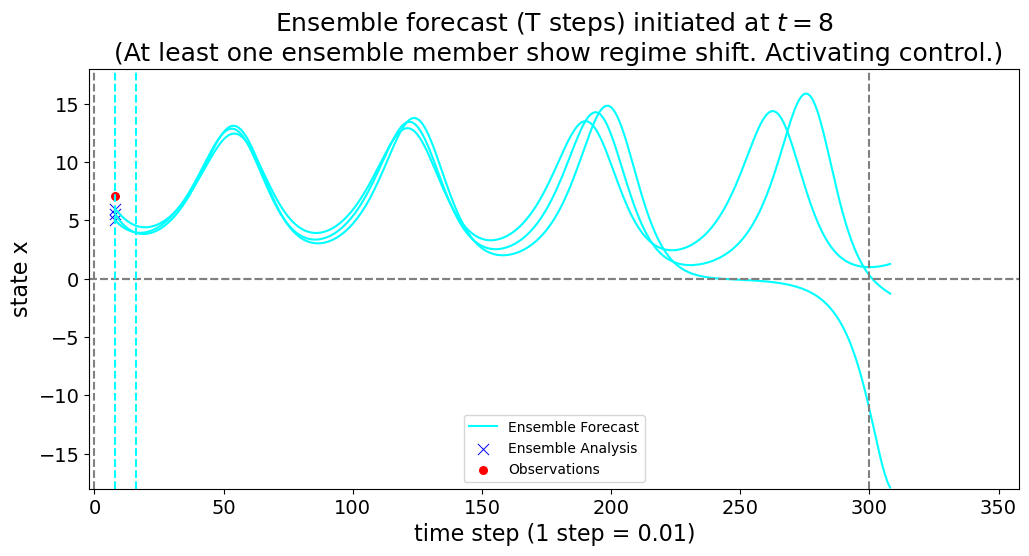

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 6.00691607  3.14333604 27.9220135 ]
 [ 5.52550802  2.12572989 26.57681564]
 [ 4.99513782  2.70610314 26.76808977]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.26809373e-01  5.47997848e-02  1.44624917e-01]
 [ 1.22375827e-01  4.86991784e-02  1.50507631e-01]
 [ 1.17693274e-01  4.31958195e-02  1.55828157e-01]
 [ 1.12822084e-01  3.82375828e-02  1.60651999e-01]
 [ 1.07818010e-01  3.37623838e-02  1.65031446e-01]
 [ 1.02727206e-01  2.96999494e-02  1.69011935e-01]
 [ 9.75867658e-02  2.59794158e-02  1.72632248e-01]
 [ 9.24336235e-02  2.25273511e-02  1.75921982e-01]
 [ 8.72983637e-02  1.92655191e-02  1.78907338e-01]
 [ 8.22067070e-02  1.61110256e-02  1.81610826e-01]
 [ 7.71795463e-02  1.29768941e-02  1.84051400e-01]
 [ 7.22326932e-02  9.77244478e-03  1.86244295e-01]
 

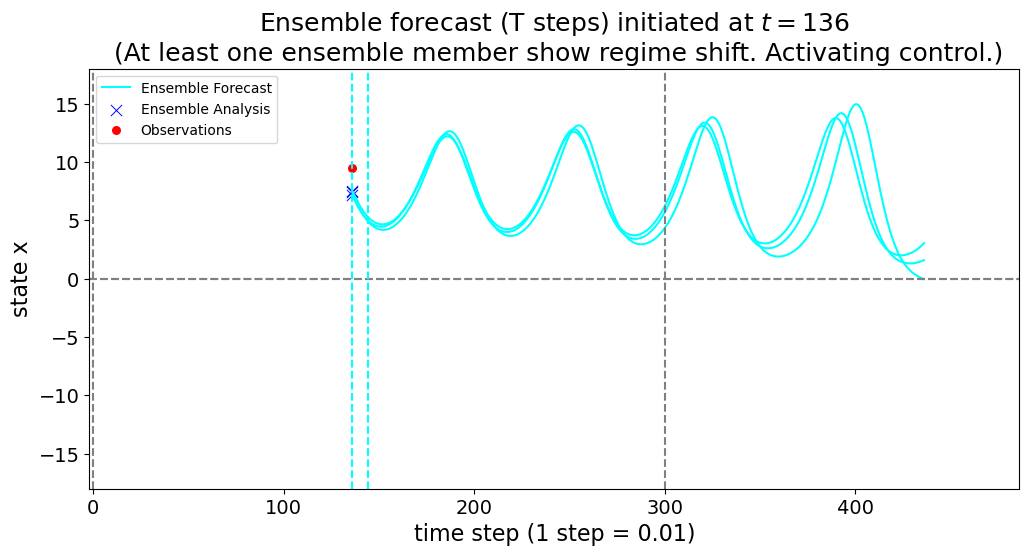

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 7.53713968  3.92743053 30.18884242]
 [ 7.41378834  3.39813508 30.49012002]
 [ 7.14638217  3.53046334 29.82826239]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[-0.07366587  0.03645419 -0.18233056]
 [-0.06442769  0.05158084 -0.18217708]
 [-0.05441961  0.0658051  -0.18085407]
 [-0.04373703  0.07913556 -0.1783946 ]
 [-0.03248993  0.09158449 -0.17480471]
 [-0.02085758  0.10318189 -0.17005428]
 [-0.00897142  0.11392572 -0.16413544]
 [ 0.00305339  0.12379212 -0.15705473]
 [ 0.01507054  0.13275035 -0.14882951]
 [ 0.02690953  0.14077061 -0.13949736]
 [ 0.03838448  0.14783284 -0.12912042]
 [ 0.04930628  0.15393366 -0.11778505]
 [ 0.05949582  0.1590898  -0.1055968 ]
 [ 0.06879579  0.16333698 -0.09267239]
 [ 0.07707908  0.16672465 -0.07913094]
 [ 0.08428441  0.16928058 -0

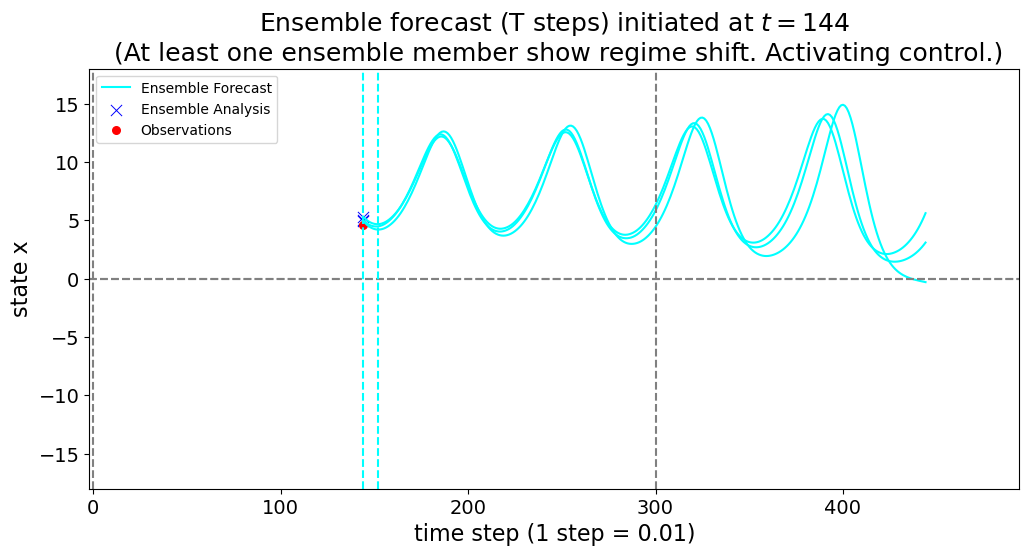

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.32946149  3.56433937 25.95234523]
 [ 4.97405728  3.01898153 25.89326301]
 [ 5.01741367  3.40756364 25.45588385]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.47806176e-02  1.32471446e-01 -1.49106839e-01]
 [ 2.66333934e-02  1.40543824e-01 -1.39778739e-01]
 [ 3.80765552e-02  1.47708372e-01 -1.29353828e-01]
 [ 4.89362562e-02  1.53947869e-01 -1.17920720e-01]
 [ 5.90551370e-02  1.59250555e-01 -1.05601854e-01]
 [ 6.83167848e-02  1.63605541e-01 -9.25529247e-02]
 [ 7.65897666e-02  1.67041794e-01 -7.89369796e-02]
 [ 8.37921250e-02  1.69596269e-01 -6.49306199e-02]
 [ 8.99168943e-02  1.71292948e-01 -5.07314316e-02]
 [ 9.49910778e-02  1.72169366e-01 -3.65295035e-02]
 [ 9.90733974e-02  1.72274523e-01 -2.24933434e-02]
 [ 1.02248148e-01  1.71664184e-01 -8.75923810e-03]
 

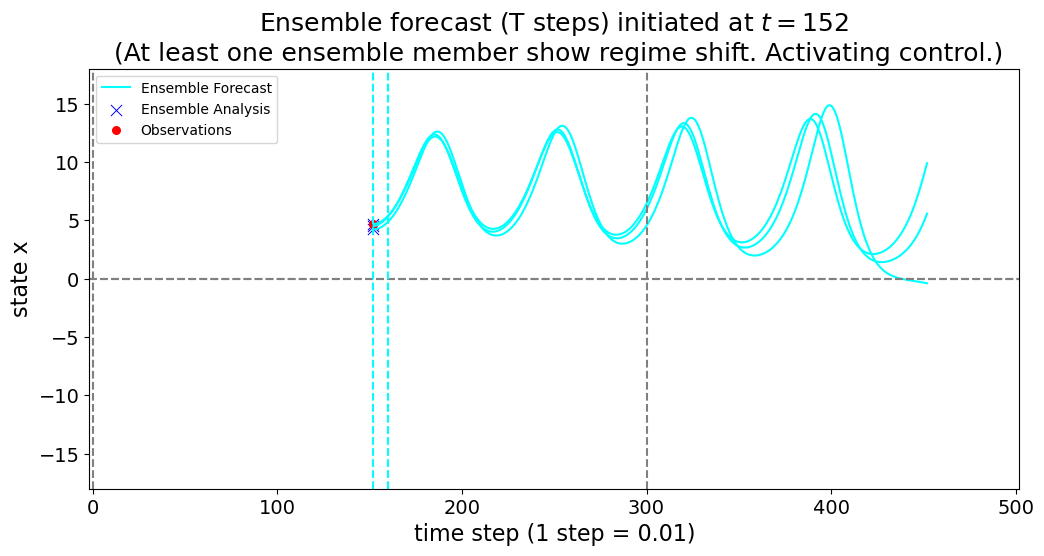

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.6820478   4.81122047 22.30721861]
 [ 4.22932174  4.26160972 21.96587659]
 [ 4.49916406  4.78035128 21.80468747]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.14664984e-01  1.39203622e-01  8.64539942e-02]
 [ 1.13353701e-01  1.36282251e-01  9.26179596e-02]
 [ 1.11847341e-01  1.33405333e-01  9.84539956e-02]
 [ 1.10187886e-01  1.30537599e-01  1.04012331e-01]
 [ 1.08410201e-01  1.27639675e-01  1.09340485e-01]
 [ 1.06543288e-01  1.24668931e-01  1.14482249e-01]
 [ 1.04620333e-01  1.21588315e-01  1.19460737e-01]
 [ 1.02622993e-01  1.18351192e-01  1.24344347e-01]
 [ 1.00551507e-01  1.14903267e-01  1.29176754e-01]
 [ 9.84092904e-02  1.11193568e-01  1.33983589e-01]
 [ 9.62010571e-02  1.07172222e-01  1.38778498e-01]
 [ 9.39307970e-02  1.02787729e-01  1.43567712e-01]
 

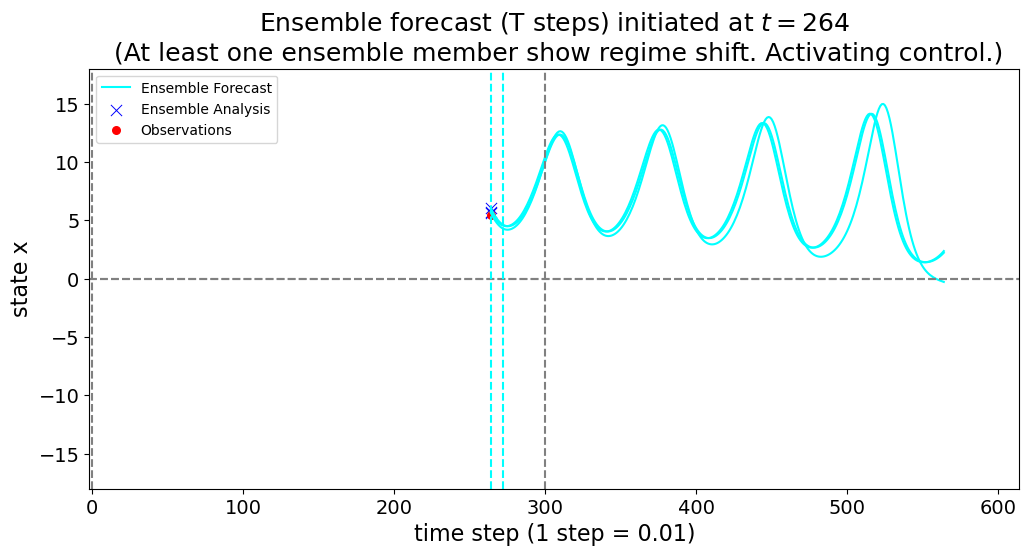

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.72951553  3.25080854 27.23955068]
 [ 6.04366649  3.26000245 27.88990388]
 [ 5.65488492  2.8901177  27.52341855]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 3.20974353e-02  1.55127388e-01 -1.22087052e-01]
 [ 4.43183393e-02  1.61261594e-01 -1.09684015e-01]
 [ 5.57086464e-02  1.65958761e-01 -9.67173007e-02]
 [ 6.61025043e-02  1.69342987e-01 -8.33871191e-02]
 [ 7.53864789e-02  1.71559997e-01 -6.98859520e-02]
 [ 8.35209117e-02  1.72752555e-01 -5.63986872e-02]
 [ 9.04602667e-02  1.73097647e-01 -4.30597808e-02]
 [ 9.62237811e-02  1.72746978e-01 -2.99910935e-02]
 [ 1.00878953e-01  1.71825873e-01 -1.73004646e-02]
 [ 1.04515907e-01  1.70442789e-01 -5.06762885e-03]
 [ 1.07240563e-01  1.68686573e-01  6.65596951e-03]
 [ 1.09167751e-01  1.66625153e-01  1.78454658e-02]
 

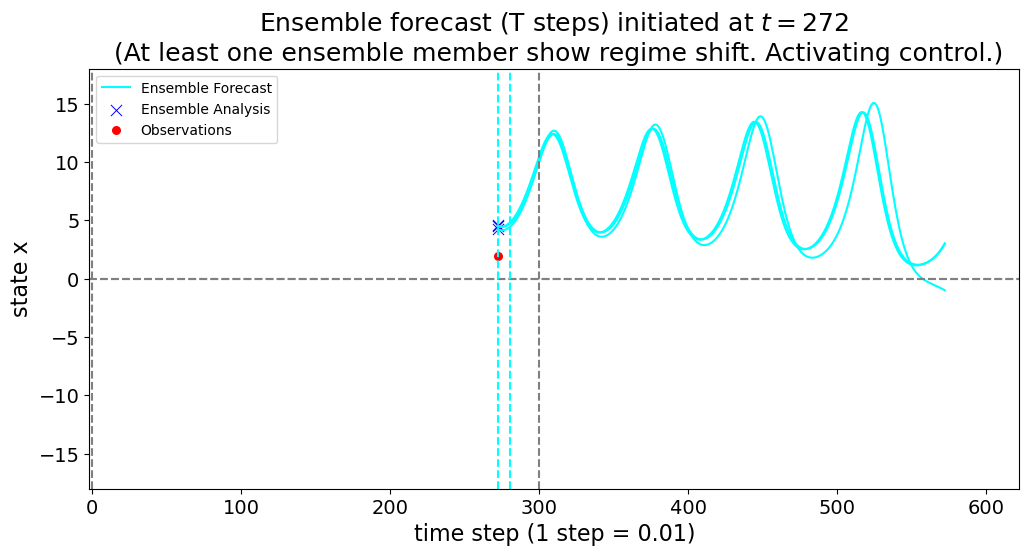

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.49023993  4.04396979 23.13536559]
 [ 4.5638228   3.84566467 23.66700148]
 [ 4.23304772  3.60482577 23.18127563]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.00665775e-01  1.71882242e-01 -1.79693229e-02]
 [ 1.04328128e-01  1.70533046e-01 -5.84139223e-03]
 [ 1.07084475e-01  1.68817195e-01  5.80258385e-03]
 [ 1.09037804e-01  1.66804788e-01  1.69387088e-02]
 [ 1.10292354e-01  1.64547684e-01  2.75618668e-02]
 [ 1.10955159e-01  1.62077853e-01  3.76792037e-02]
 [ 1.11136489e-01  1.59408367e-01  4.73038407e-02]
 [ 1.10874982e-01  1.56572404e-01  5.64962002e-02]
 [ 1.10232948e-01  1.53575174e-01  6.52944348e-02]
 [ 1.09272633e-01  1.50410179e-01  7.37310634e-02]
 [ 1.08054422e-01  1.47060363e-01  8.18382047e-02]
 [ 1.06634587e-01  1.43498531e-01  8.96506358e-02]
 

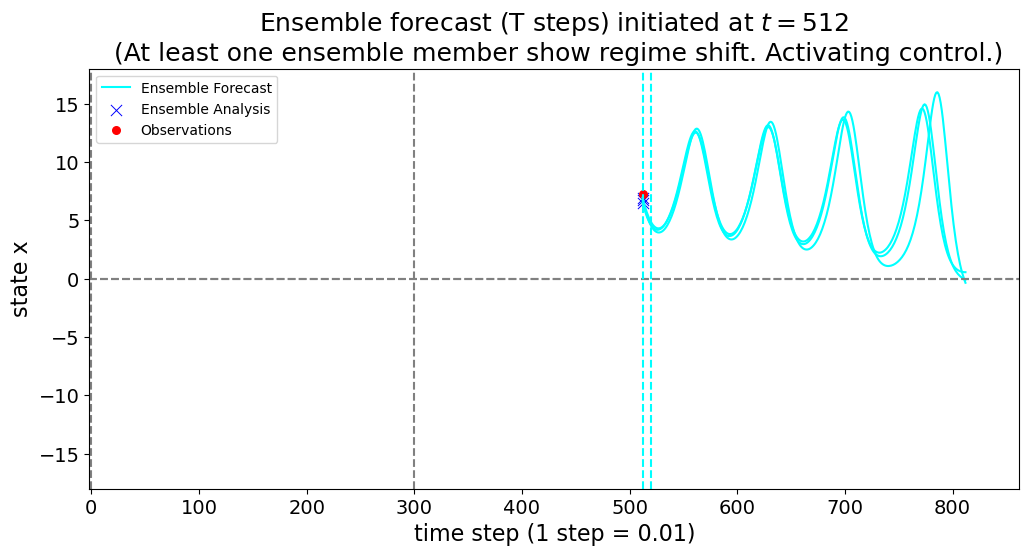

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 6.78548809  2.87828871 29.80430761]
 [ 6.53139116  3.02253352 29.14922894]
 [ 6.94935755  3.29840019 29.68031828]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.11451626  0.07558316  0.14551018]
 [ 0.11217598  0.0650445   0.15226872]
 [ 0.10921177  0.05528995  0.15816387]
 [ 0.10571564  0.04630333  0.16334076]
 [ 0.10176921  0.03804328  0.16791587]
 [ 0.09748758  0.03041093  0.17196321]
 [ 0.0929655   0.02330742  0.17553968]
 [ 0.08820355  0.01669904  0.17872122]
 [ 0.08320341  0.01054197  0.18156558]
 [ 0.07797141  0.00478001  0.18411304]
 [ 0.07252054 -0.00065743  0.1863876 ]
 [ 0.06687205 -0.00585794  0.18839802]
 [ 0.06105652 -0.01092925  0.19013851]
 [ 0.05511418 -0.01600268  0.19158899]
 [ 0.04909456 -0.02123699  0.19271407]
 [ 0.04305544 -0.0268225   0

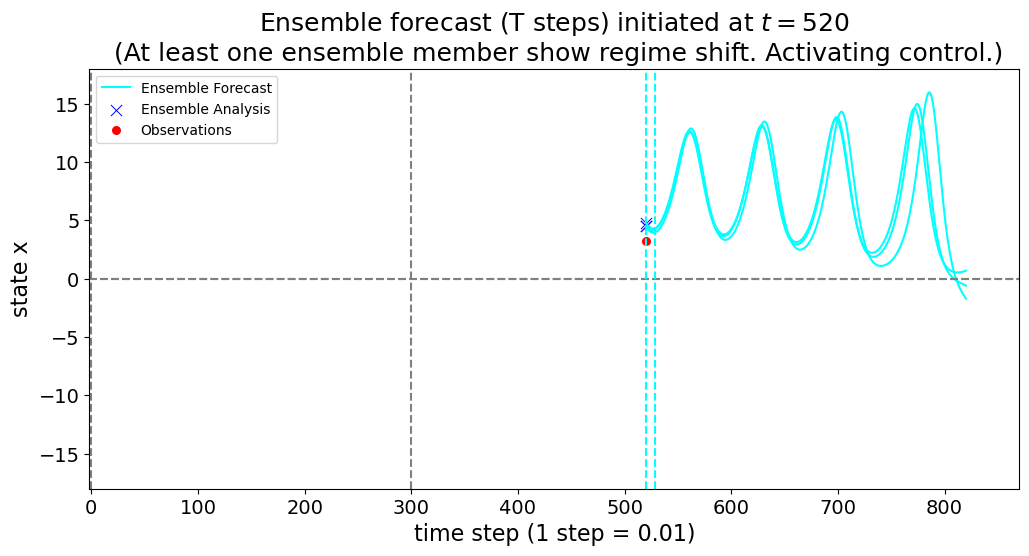

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.49453822  2.8420436  25.04796227]
 [ 4.54009671  3.21320582 24.60889123]
 [ 4.79551112  3.24659261 25.16474244]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.16301539e-01  1.56325279e-01  4.51260364e-02]
 [ 1.17474838e-01  1.52798995e-01  5.34053334e-02]
 [ 1.18019708e-01  1.49492537e-01  6.10190949e-02]
 [ 1.18035930e-01  1.46418199e-01  6.80384455e-02]
 [ 1.17614349e-01  1.43569042e-01  7.45304973e-02]
 [ 1.16847816e-01  1.40916811e-01  8.05545800e-02]
 [ 1.15789517e-01  1.38437598e-01  8.61847969e-02]
 [ 1.14475751e-01  1.36116551e-01  9.14745146e-02]
 [ 1.12964678e-01  1.33918036e-01  9.64621237e-02]
 [ 1.11309836e-01  1.31798881e-01  1.01188810e-01]
 [ 1.09559497e-01  1.29709783e-01  1.05698102e-01]
 [ 1.07756092e-01  1.27596586e-01  1.10035158e-01]
 

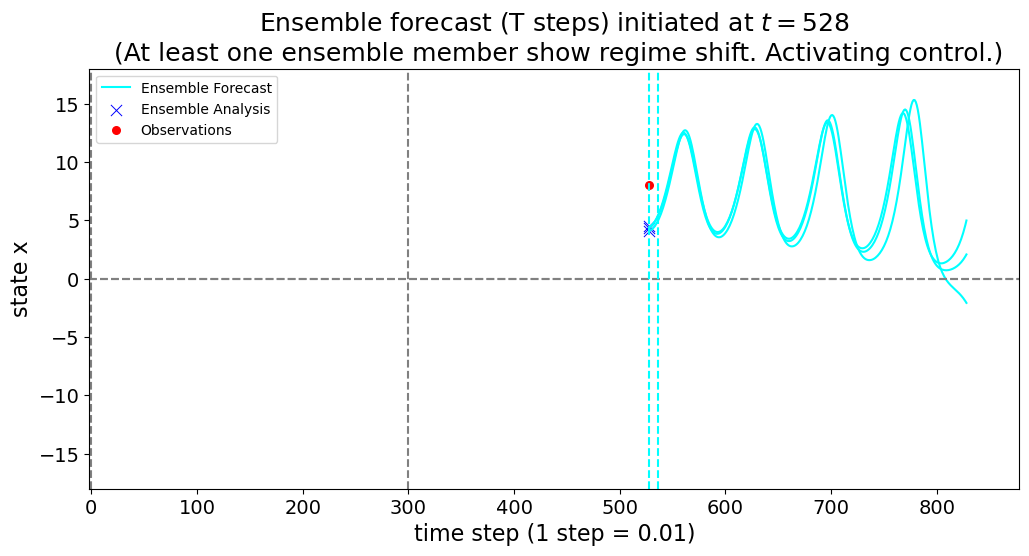

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.11930161  4.37294328 21.39157885]
 [ 4.38426677  4.88286402 21.2135318 ]
 [ 4.47960901  4.79916352 21.70114816]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.08808635  0.16952061 -0.05919085]
 [ 0.09332118  0.17116353 -0.0446565 ]
 [ 0.09758263  0.17195714 -0.03013919]
 [ 0.10092112  0.17194564 -0.01579947]
 [ 0.10340953  0.1711822  -0.0017676 ]
 [ 0.10513592  0.16972261  0.01186059]
 [ 0.10621075  0.16762093  0.02494999]
 [ 0.10671173  0.16494018  0.03751458]
 [ 0.10670411  0.16171291  0.04963029]
 [ 0.1062485   0.15795619  0.06132778]
 [ 0.10540435  0.15367892  0.07261344]
 [ 0.10422982  0.1488832   0.08348616]
 [ 0.1027793   0.14356194  0.09394884]
 [ 0.10110014  0.13769433  0.10401458]
 [ 0.09922908  0.13124042  0.11370814]
 [ 0.0971891   0.12413539  0

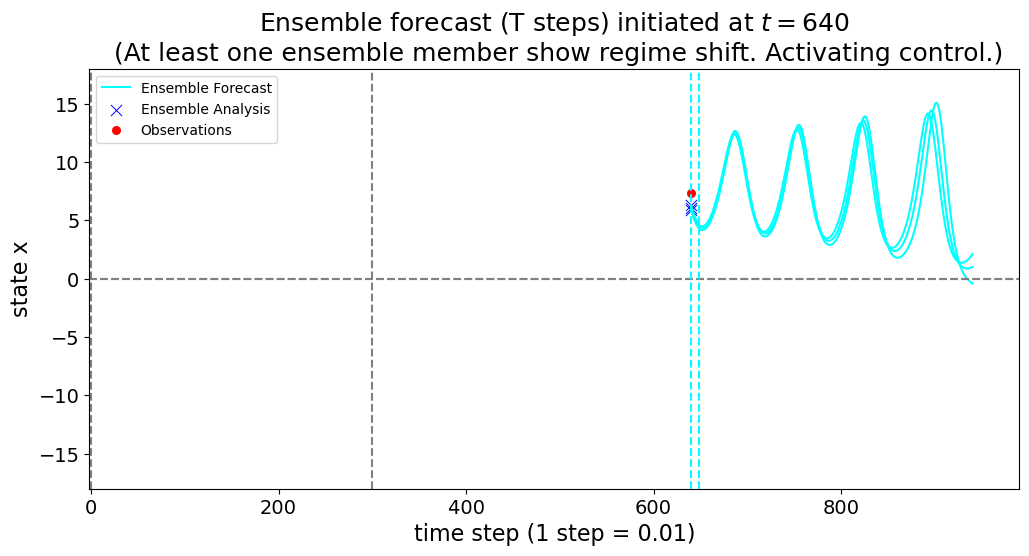

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 6.32203516  3.15248782 28.58482313]
 [ 5.91520758  2.87370403 28.07816046]
 [ 6.060394    3.24728227 27.93811778]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.06839372  0.17598345 -0.06597063]
 [ 0.07822298  0.17672331 -0.05147852]
 [ 0.08675019  0.17627064 -0.03745755]
 [ 0.0939755   0.17490227 -0.02403751]
 [ 0.09994751  0.17286658 -0.01129773]
 [ 0.10477429  0.170358    0.00070855]
 [ 0.10852484  0.16756579  0.01200263]
 [ 0.11129818  0.16462683  0.02259916]
 [ 0.11321087  0.16163523  0.03251697]
 [ 0.11437994  0.15865368  0.04178803]
 [ 0.1149201   0.1557168   0.05045443]
 [ 0.11494151  0.15283487  0.05856578]
 [ 0.11454813  0.14999778  0.06617699]
 [ 0.11383644  0.14717871  0.07334638]
 [ 0.11289459  0.14433763  0.08013402]
 [ 0.11180171  0.14142415  0

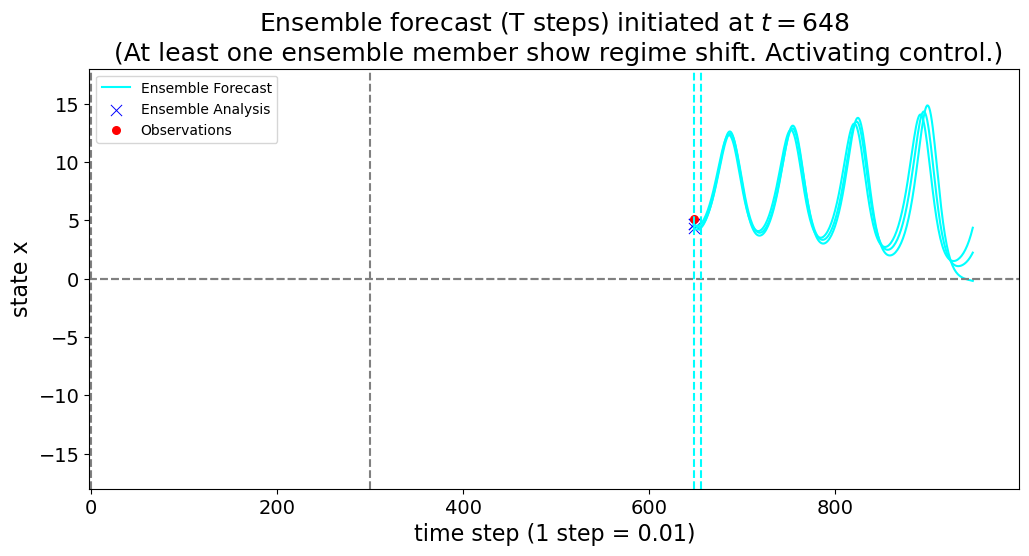

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.64957245  3.60180179 24.28273384]
 [ 4.38009134  3.51108913 23.73658402]
 [ 4.65915886  3.91036295 23.81540149]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.08753165  0.02946488  0.17739795]
 [ 0.083229    0.02528692  0.18009305]
 [ 0.07888044  0.02128815  0.18255052]
 [ 0.07450253  0.01738654  0.18478929]
 [ 0.07010548  0.01349926  0.18682342]
 [ 0.06568983  0.00954383  0.18866309]
 [ 0.06117893  0.00547259  0.19033442]
 [ 0.05655707  0.0012034   0.19183287]
 [ 0.05184363 -0.00336738  0.19313441]
 [ 0.04704844 -0.00834451  0.19420817]
 [ 0.04217012 -0.01383455  0.19501355]
 [ 0.03719438 -0.01994623  0.1954961 ]
 [ 0.03209241 -0.0267905   0.19558207]
 [ 0.02681936 -0.03447953  0.19517142]
 [ 0.02131337 -0.04312379  0.19412903]
 [ 0.01549539 -0.05282582  0

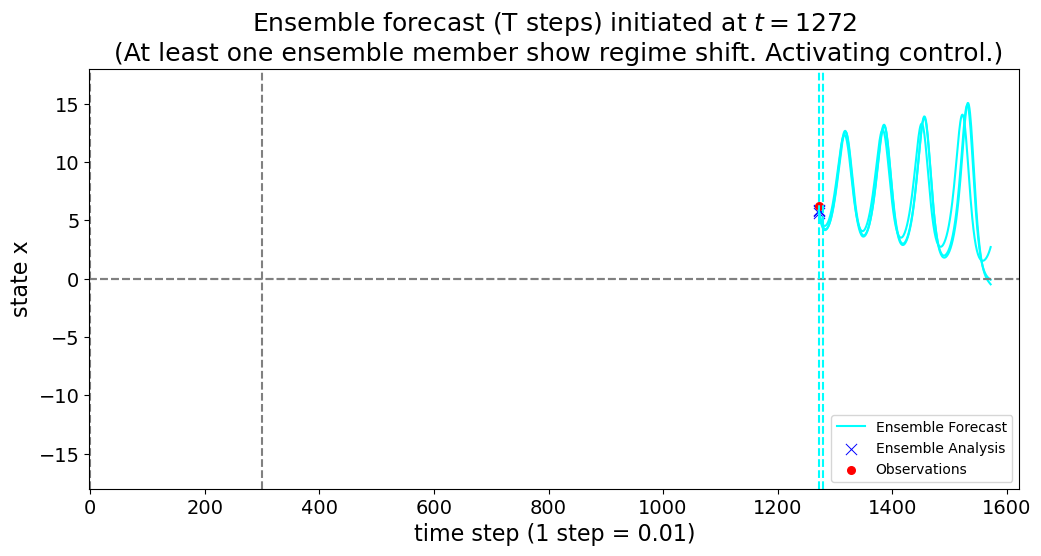

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.59373641  2.8503382  27.44405914]
 [ 5.78514196  3.27828878 27.32121994]
 [ 5.88757558  2.95377227 27.92950369]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[-0.0293926   0.09311772 -0.17454273]
 [-0.01777864  0.10443532 -0.16963839]
 [-0.00590511  0.11493153 -0.16357222]
 [ 0.00606852  0.12459802 -0.1563282 ]
 [ 0.01797007  0.13341961 -0.14790634]
 [ 0.02964254  0.14136111 -0.13834145]
 [ 0.04088339  0.14841112 -0.12768198]
 [ 0.05151966  0.15455828 -0.1160063 ]
 [ 0.06140301  0.15978206 -0.10343773]
 [ 0.07040365  0.1640704  -0.09013452]
 [ 0.0784215   0.16742523 -0.07628146]
 [ 0.08539448  0.16986534 -0.06207696]
 [ 0.09130226  0.17142597 -0.04771827]
 [ 0.09616524  0.17215552 -0.03338747]
 [ 0.10003905  0.1721104  -0.01924054]
 [ 0.10300624  0.17134919 -0

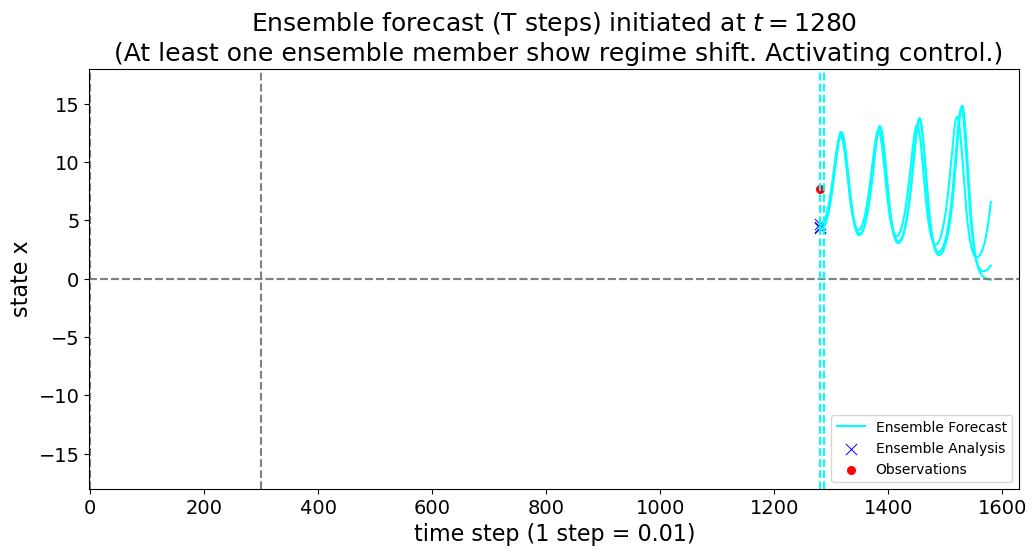

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.33073945  3.73250221 23.2285091 ]
 [ 4.65947946  4.18594608 23.35343674]
 [ 4.46903982  3.68853049 23.67737969]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.05863327 -0.01864208  0.19030137]
 [ 0.05238763 -0.02469182  0.19143106]
 [ 0.0459997  -0.03088037  0.19217292]
 [ 0.03945766 -0.03730664  0.19248716]
 [ 0.0327426  -0.04406708  0.19231749]
 [ 0.02582447 -0.0512516   0.19158907]
 [ 0.01861817 -0.05889881  0.19022169]
 [ 0.01109671 -0.0670887   0.18808501]
 [ 0.00325572 -0.07590283  0.18500854]
 [-0.00490296 -0.08538401  0.1807914 ]
 [-0.01336557 -0.09552287  0.17520486]
 [-0.02209926 -0.10624234  0.16800056]
 [-0.03104392 -0.1173819   0.15892692]
 [-0.04010463 -0.12868526  0.14775562]
 [-0.04914701 -0.139797    0.13431816]
 [-0.05799865 -0.15027452  0

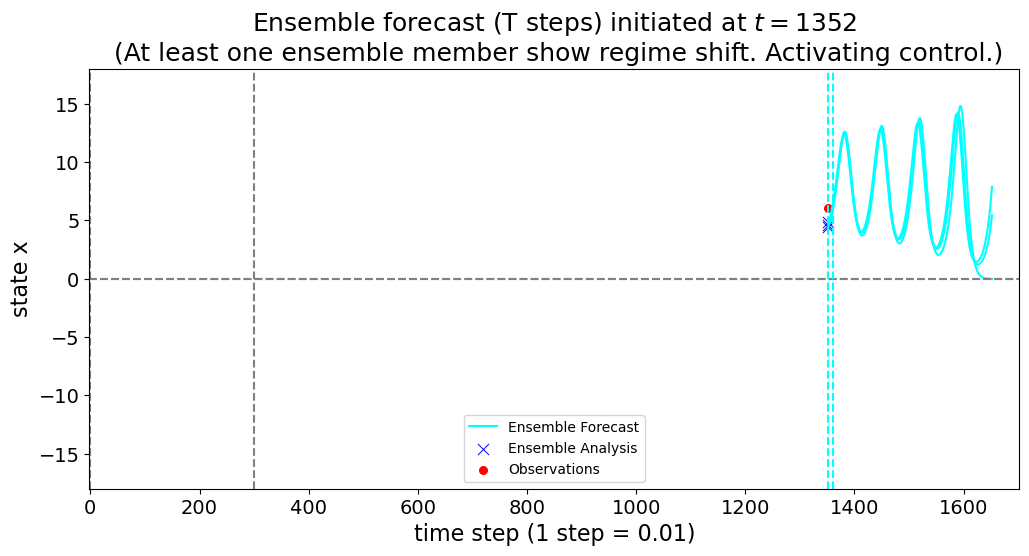

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.4437918   5.37240096 20.36938161]
 [ 4.82505423  5.94173313 20.50604007]
 [ 4.62204865  5.48110014 20.78354661]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.09135471e-01  1.62969992e-01  3.91181611e-02]
 [ 1.09187765e-01  1.60013903e-01  4.97351277e-02]
 [ 1.08819099e-01  1.56752269e-01  5.98926526e-02]
 [ 1.08097871e-01  1.53189917e-01  6.96254242e-02]
 [ 1.07082808e-01  1.49320346e-01  7.89728211e-02]
 [ 1.05822121e-01  1.45126174e-01  8.79776802e-02]
 [ 1.04352247e-01  1.40658339e-01  9.65703900e-02]
 [ 1.02702285e-01  1.35904786e-01  1.04795658e-01]
 [ 1.00882518e-01  1.30711175e-01  1.12859675e-01]
 [ 9.88906175e-02  1.24958134e-01  1.20855743e-01]
 [ 9.67192871e-02  1.18561027e-01  1.28796981e-01]
 [ 9.43603538e-02  1.11465160e-01  1.36644216e-01]
 

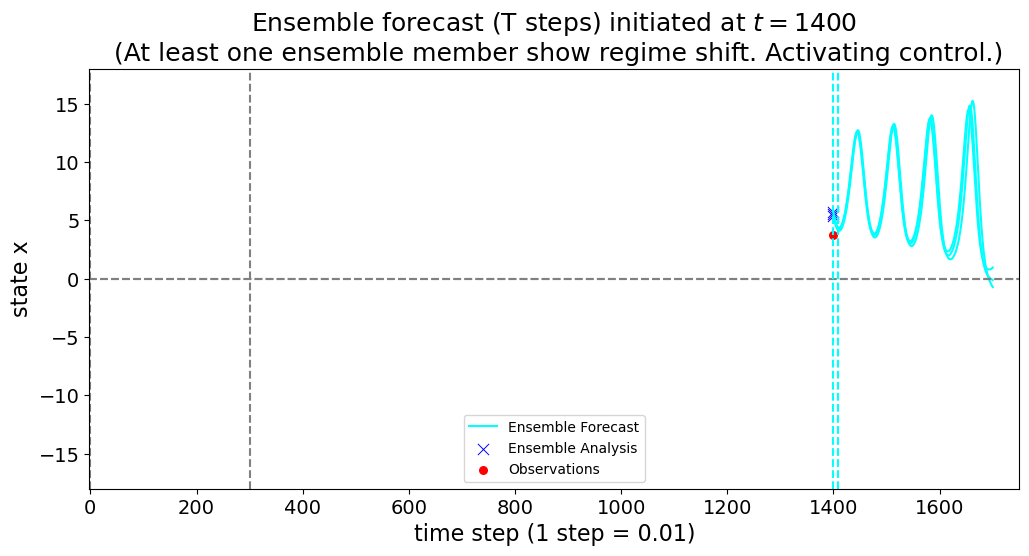

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.5253296   2.77974472 27.38592031]
 [ 5.35042343  2.97638692 26.77664683]
 [ 5.70456754  3.09249977 27.38133728]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.09971433  0.03269323  0.17025923]
 [ 0.09509709  0.02491975  0.17417103]
 [ 0.09016594  0.01770234  0.17764214]
 [ 0.08497169  0.01095727  0.18072009]
 [ 0.07955882  0.00459502  0.1834374 ]
 [ 0.07395924 -0.00147915  0.18581669]
 [ 0.06820005 -0.00736167  0.18786846]
 [ 0.06229641 -0.01314811  0.18959505]
 [ 0.05625453 -0.01893637  0.19098912]
 [ 0.05007693 -0.0248283   0.19203088]
 [ 0.04376269 -0.03092919  0.19268682]
 [ 0.03730747 -0.03734703  0.19290762]
 [ 0.03070364 -0.04419113  0.1926251 ]
 [ 0.02394061 -0.05156975  0.19174829]
 [ 0.01700578 -0.05958597  0.19015866]
 [ 0.00984116 -0.06825533  0

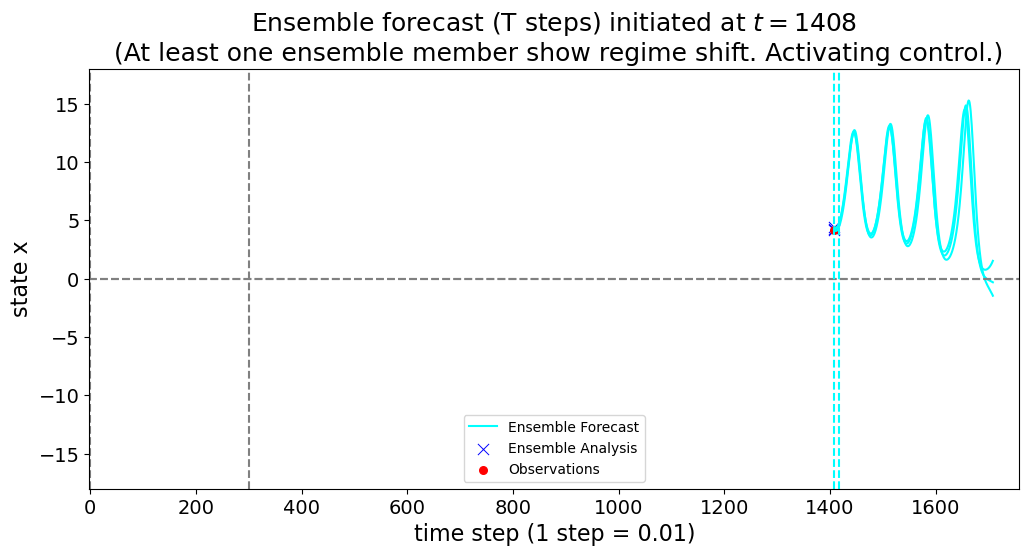

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.19032334  3.53795166 23.17614596]
 [ 4.27791127  3.90392693 22.77681722]
 [ 4.44233683  3.850549   23.33158438]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 5.65932910e-02 -1.83720359e-02  1.90944148e-01]
 [ 5.04944958e-02 -2.42570424e-02  1.91994536e-01]
 [ 4.42614525e-02 -3.03439399e-02  1.92665952e-01]
 [ 3.78761718e-02 -3.67301236e-02  1.92915250e-01]
 [ 3.13134945e-02 -4.35104981e-02  1.92681866e-01]
 [ 2.45390505e-02 -5.07741517e-02  1.91884915e-01]
 [ 1.74760736e-02 -5.85619117e-02  1.90433950e-01]
 [ 1.00866292e-02 -6.69501984e-02  1.88191208e-01]
 [ 2.35467067e-03 -7.60173503e-02  1.84975182e-01]
 [-5.72781052e-03 -8.57982819e-02  1.80570892e-01]
 [-1.41541060e-02 -9.62698703e-02  1.74733435e-01]
 [-2.28945388e-02 -1.07334394e-01  1.67197990e-01]
 

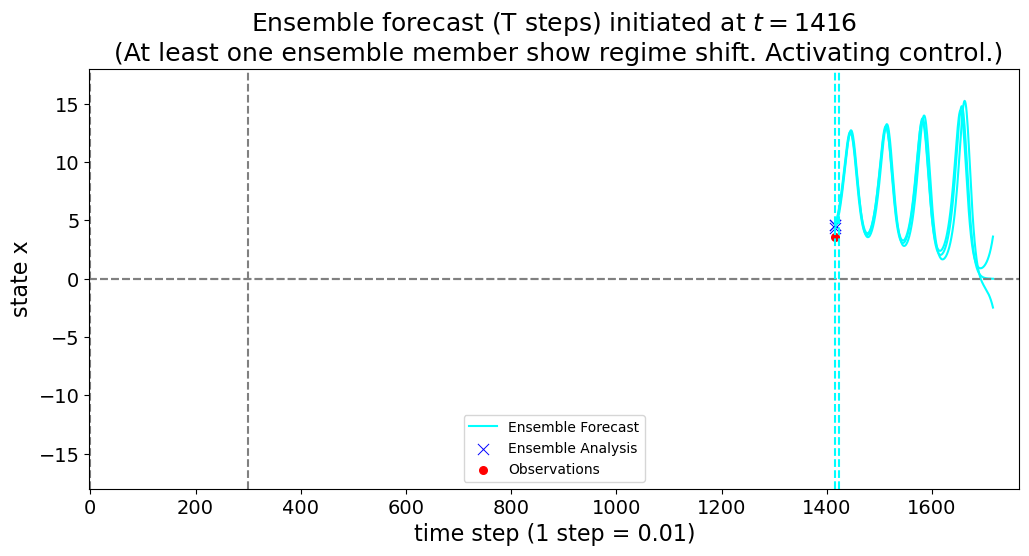

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.34800972  5.3182641  20.1347255 ]
 [ 4.63522471  5.84178401 20.01497907]
 [ 4.64162412  5.66248792 20.45448185]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 1.05993217e-01  1.24262944e-01  1.15430320e-01]
 [ 1.04161301e-01  1.21690464e-01  1.19757481e-01]
 [ 1.02281468e-01  1.18985394e-01  1.24020068e-01]
 [ 1.00360656e-01  1.16100177e-01  1.28251658e-01]
 [ 9.84017453e-02  1.12984788e-01  1.32482203e-01]
 [ 9.64031088e-02  1.09586283e-01  1.36738024e-01]
 [ 9.43628175e-02  1.05927339e-01  1.40978926e-01]
 [ 9.22599629e-02  1.01928046e-01  1.45254166e-01]
 [ 9.00688433e-02  9.74392804e-02  1.49643543e-01]
 [ 8.77661484e-02  9.23489594e-02  1.54171245e-01]
 [ 8.53302323e-02  8.65751683e-02  1.58819053e-01]
 [ 8.27401420e-02  8.00589313e-02  1.63537875e-01]
 

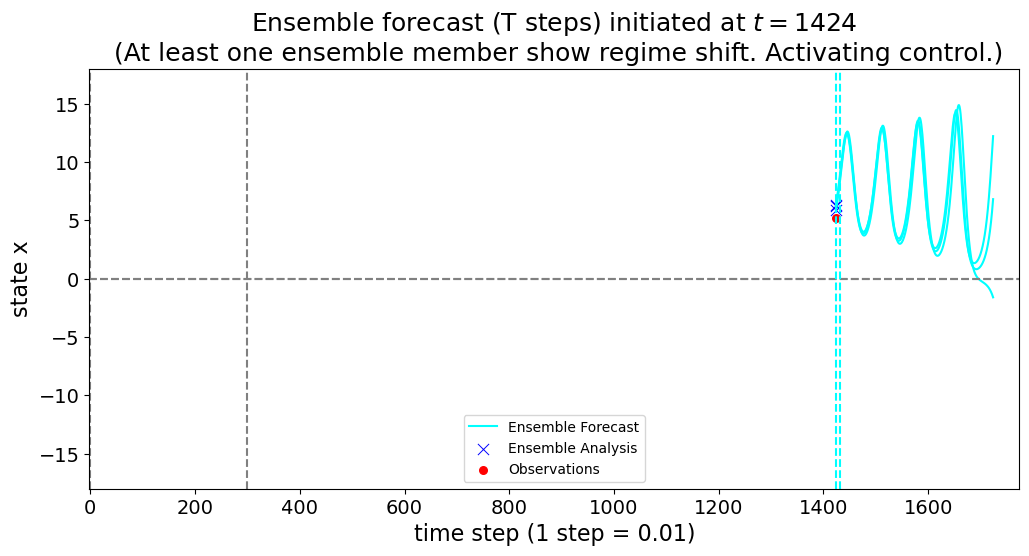

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.89640521  8.45505274 18.90584644]
 [ 6.35366395  9.13416069 19.21944762]
 [ 6.21191848  8.79156579 19.44170764]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.08924626  0.09518627  0.151574  ]
 [ 0.08695189  0.08964294  0.15621624]
 [ 0.08451305  0.08348189  0.16089848]
 [ 0.08190118  0.07661813  0.16559547]
 [ 0.07908271  0.06896646  0.17026318]
 [ 0.07601674  0.06043425  0.17484038]
 [ 0.07264847  0.05087218  0.17926021]
 [ 0.06894213  0.04031451  0.18336227]
 [ 0.06483468  0.02861907  0.18702249]
 [ 0.0602364   0.01563975  0.19007097]
 [ 0.05503986  0.00126658  0.19227327]
 [ 0.04912707 -0.01455811  0.19332509]
 [ 0.04237771 -0.03181863  0.19285151]
 [ 0.03467865 -0.05040237  0.19041269]
 [ 0.02593387 -0.07007781  0.18551694]
 [ 0.01607222 -0.09047942  0

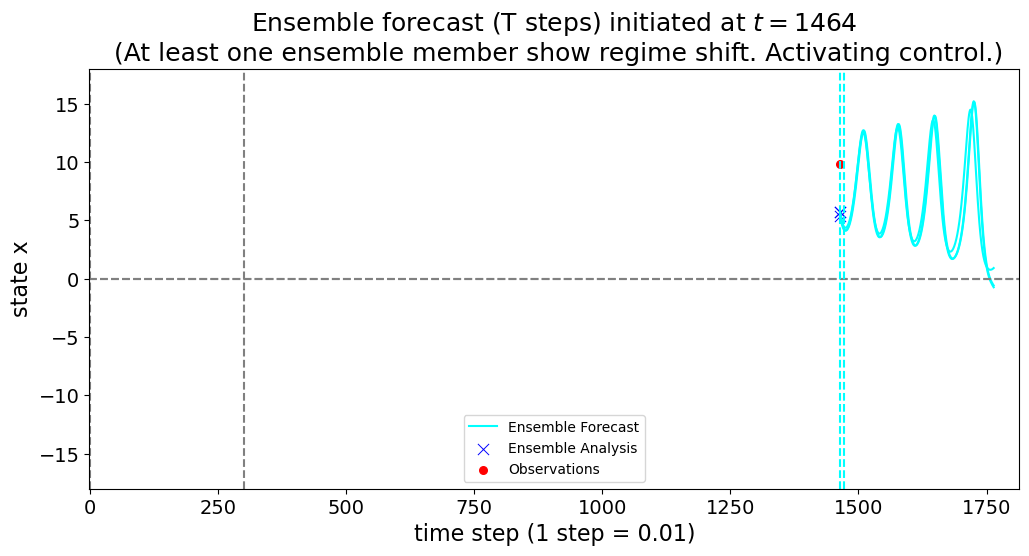

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 5.72090528  2.81505956 27.74982733]
 [ 5.38697332  2.80572717 27.06994195]
 [ 5.71490773  3.08686484 27.41008602]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 0.11929279  0.10226952  0.12373429]
 [ 0.11791142  0.0961063   0.1298479 ]
 [ 0.1161092   0.09060685  0.13531095]
 [ 0.11396839  0.08573624  0.14021592]
 [ 0.11156265  0.0814457   0.14463877]
 [ 0.10896096  0.07767183  0.14864251]
 [ 0.10619885  0.07435895  0.15229101]
 [ 0.10332072  0.07145163  0.15562613]
 [ 0.10037279  0.06888523  0.15868247]
 [ 0.09739784  0.06658833  0.16149197]
 [ 0.09443561  0.06448333  0.16408478]
 [ 0.09152292  0.06248706  0.16649001]
 [ 0.0886935   0.0605112   0.16873606]
 [ 0.08597764  0.05846263  0.17085071]
 [ 0.08340172  0.05624363  0.17286066]
 [ 0.08091305  0.05388981  0

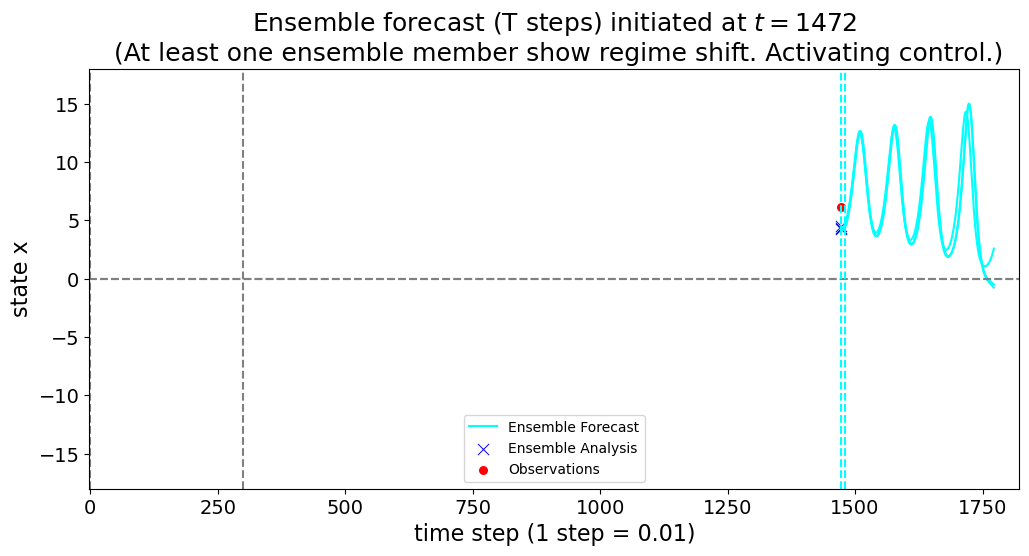

Plotting complete
CSE System Step 4a
At least one ensemble member show regime shift. Activating control.
initial condition shift Xf[:,0,:]: [[ 4.32942709  3.53550938 23.56255968]
 [ 4.24208982  3.71891742 23.00446289]
 [ 4.50973482  3.90433993 23.42458901]]
 perturbation_vector shape: (301, 3)
check perturbations are normalized:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
perturb_vec: [[ 8.32622014e-02  1.70317951e-01 -6.37118631e-02]
 [ 8.98192936e-02  1.71510165e-01 -5.01672973e-02]
 [ 9.52954132e-02  1.71959523e-01 -3.67247441e-02]
 [ 9.97388320e-02  1.71753719e-01 -2.35122399e-02]
 [ 1.03221905e-01  1.70974244e-01 -1.06323260e-02]
 [ 1.05841907e-01  1.69688307e-01  1.83550124e-03]
 [ 1.07720263e-01  1.67943969e-01  1.38263606e-02]
 [ 1.08905136e-01  1.65822855e-01  2.53466376e-02]
 [ 1.09475864e-01  1.63371824e-01  3.63961870e-02]
 [ 1.09516257e-01  1.60621438e-01  4.69781116e-02]
 [ 1.09111554e-01  1.57587535e-01  5.71037439e-02]
 [ 1.08344725e-01  1.54271932e-01  6.67951459e-02]
 

In [202]:
"""
The Control Simulation Experiment follows these steps:

1. Perform a DA update using the observations at time t = 0.

2. Run an ensemble forecast for T steps from time t to t+T (T = 4 To).

3. If at least one ensemble member shows the regime shift, activate the control (Step 4); otherwise go to Step 1 for the next DA at time t + Ta. Ta = 8 steps.

4. Add perturbations with Euclidean norm D to the NR at every step from t + 1 to t + Ta - 1. At time t + i (i = 1, ..., Ta - 1), the NR
is evolved from the previous NR state at time t + i - 1 and is perturbed by adding (dx, dy, dz), where D = sqrt(dx^2 + dy^2 + dz^2).

5. At time t + Ta, the new NR is used to simulate the observations; go to Step 1 for the next DA at time t + Ta.
"""

print(' * * * Starting the Control Simulation Experiment * * *')
print(' * * * DA update using the observations at time t = 0 * * *')
print('       We choose t = 105768 as the starting time for the control simulation experiment.')


#------------------------------------------------------------
# Defining some useful functions:
#------------------------------------------------------------
# Defining the function to detect regime shifts:
def detect_regime_shift(forecast):
    return np.any(forecast < 0)

# Defining the function to classify ensemble members:
def classify_ensemble(xf_4d):
    predicted_changes = []
    safe_members = []
    for k in range(xf_4d.shape[0]):
        if detect_regime_shift(xf_4d[k, :, 0]):
            predicted_changes.append(k)
        else:
            safe_members.append(k)
    return predicted_changes, safe_members

# Defining the function to compute perturbation vector:
def compute_perturbation(xf_safe, xf_shift, D):
    delta = xf_safe - xf_shift
    return delta / (np.linalg.norm(delta) * D)

# Defining the function to evolve nature with control:
def evolve_nature_with_control(x_init, perturb_vec, solver, steps):
    x = x_init.copy()
    history = []
    for q in range(steps):
        x_perturbed = x + perturb_vec[q, :]
        x_next = solver.run(x_perturbed, np.arange(0, 0.015, 0.01), np.arange(0, 0.015, 0.01))[1, :]
        history.append(x_perturbed)
        x = x_next
    return x, history


#-----------------------------------------------------------
# Initializing ensemble:
#-----------------------------------------------------------
das.x0   = x_nature[:,105768]        # initial condition (time = 105768)
xa       = das.x0
Xa       = das.initEns(xa, mu = das.ens_bias_init, sigma = das.ens_sigma_init, edim = das.edim, separate = 'no')

#-----------------------------------------------------------
# Get observations:
#-----------------------------------------------------------
obs.setVal(y_obs[:,105768])
yo = obs.getVal()

#--------------------------------------------------------------------
# CREATE HISTORY OF ENSEMBLE FORECAST:
# Run a long ensemble forecast for 8000 time steps.
#--------------------------------------------------------------------
position   = 8000
Xf_history = np.zeros((das.edim, position, das.xdim))
Xf         = Xa.copy()

# Create the RK4 solver:
solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)

# Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
for k in range(das.edim):
    xf_ens = solver.run(np.ravel(Xa[:,k]),np.arange(0,0.01 * position,0.01),np.arange(0,0.01 * position,0.01))
    Xf_history[k,:,:] = xf_ens



#--------------------------------------------------------------------
#
# Starting DA cycle:
#
#--------------------------------------------------------------------
Xf               = Xa.copy()
xf_4d_history    = []          # Initialize the history of ensemble forecast
x_nature_control = []          # Initialize the history of nature run with control
cse_system       = cse()
t_index          = 0
Ta               = 8
D                = 0.2   # Euclidean norm perturbation
#D                = 0.1   # Euclidean norm perturbatio
num_cycles       = 300
t_final          = Ta
x_original       = evo_history[:,0].copy()  # Initial condition for the control simulation

while t_index < num_cycles*Ta:
    #----------------------------------------------
    # STEP 1: PERFORM DA UPDATE:
    #----------------------------------------------
    print('\n * * * STEP 1: DA update using the observations at time t = 0 * * *')
    cse_system.t_index = t_index
    print('t_index: ', t_index)
    Xa, KH     = cse_system.CSE_Step1(Xf, yo, das)
    print(f'Xf: {Xf}')
    print(f'Xa: {Xa}')
    #--------------------------------------------------------------------
    # STEP 2: RUN ENSEMBLE FORECAST:
    # Run an ensemble forecast for T steps from time t to t+T (T = 4 To).
    #--------------------------------------------------------------------
    print('\n * * * STEP 2: RUN ENSEMBLE FORECAST * * *')
    multiple_number = 4       # This is the  parameter before To in the paper 
    T_0 = 75.1
    # Create the RK4 solver:
    solver = run_RK4(lorenz63, sigma, beta, rho, np.ravel(Xf[:,0]), 0.01, 0.01 * position)
    # Run forecast for each ensemble member, using the initial condition from the posterior ensemble:
    xf_4d  = cse_system.CSE_Step2(multiple_number, T_0, solver, Xa, das)
    print(f'initial condition xf_4d[:,0,:]: {xf_4d[:,0,:]}')
    xf_4d_history.append(xf_4d[:,0,:].copy())  # Save the ensemble forecast history
    cse_system.history = xf_4d_history.copy()  # Save the history of ensemble forecast
    cse_system.xf4d = xf_4d.copy()  # Save the ensemble forecast for plotting
    # Plotting the ensemble forecast:
    #cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 3: REGIME SHIFT: Checking regime shift
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 3: CHECKING REGIME SHIFT * * *')
    predicted_changes, safe_members = cse_system.CSE_Step3(xf_4d)
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 4: CONTROL STEP: If regime shift is detected, activate the control. Otherwise, go to Step 1 for the next DA at time t + Ta.
    #------------------------------------------------------------------------------------------------------------------------------------
    if len(predicted_changes) > 0 and len(predicted_changes) < das.edim:
        print('Regime shift detected, activating control.')
        print('\n * * * STEP 4: CONTROL STEP * * *')
        cse_system.Plot_Ensemble_Fcst_Step4(xf_4d, Xa, yo, cse_system.t_index, cse_system.T_0, cse_system.multiple_number, title = 'Ensemble forecast (T steps) initiated at $t = $'+str(cse_system.t_index)+'\n (At least one ensemble member show regime shift. Activating control.)')
        #x_final, x_final_history = cse_system.CSE_Step4(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
        x_final, x_final_history = cse_system.CSE_Step4a(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
        #cse_system.Plot_Ensemble_Fcst_Step2(x_nature, xf_4d, Xa, t_index, T_0, multiple_number)
        #print(f'Regime shift detected. Final state after control: {x_final}')
        #print(f'Regime shift detected. Final history state after control: {x_final_history}')
        #break
    elif len(predicted_changes) == das.edim:
        print('Regime shift detected in all ensemble members, applying control to all.')
        print('\n * * * STEP 4: CONTROL STEP * * *')
        cse_system.Plot_Ensemble_Fcst_Step4(xf_4d, Xa, yo, cse_system.t_index, cse_system.T_0, cse_system.multiple_number, title = 'Ensemble forecast (T steps) initiated at $t = $'+str(cse_system.t_index)+'\n (All ensemble members show regime shift.)')
        x_final, x_final_history = cse_system.CSE_Step4b(predicted_changes, safe_members, xf_4d, x_original, solver, Ta, D, das)
        #break
    else:
        print('No regime shift detected. No control applied.')
        print('next DA at time t + Ta: ', t_index + Ta)
        x_final, x_history = cse_system.CSE_Step3b(xf_4d, x_original, solver, Ta, D, das)
        x_final_history = x_history  # Save the final state history without control
        #print(f'No regime shift detected. Final state after control: {x_final}')
        #print(f'Regime shift detected. Final history state after control: {x_final_history}')
        #break
    print(f'Final state after control: {x_final}')
    print(f'Final state history after control: {x_final_history}')
    print(f'shape of x_final_history: {np.shape(x_final_history)}')
    x_original = x_final.copy()  # Update the original state for the next cycle
    print(f'x_final_history_main: {x_final_history}')
    cse_system.history_final.append(x_final_history.copy())
    x_nature_control.extend(x_final_history.copy())  # Save the nature run with control])
    t_index += Ta
    #------------------------------------------------------------------------------------------------------------------------------------
    # STEP 5: Simulate new observations; go to Step 1 for the next DA at time t + Ta.:
    #------------------------------------------------------------------------------------------------------------------------------------
    print('\n * * * STEP 5: New NR used to simulate observations at t + Ta * * *')
    yo_new = cse_system.CSE_Step5(x_final, das)
    # Update observations for the next DA cycle
    yo = yo_new.copy()
    cse_system.yo_history.append(yo_new.copy())
    print(f'yo_new: {yo_new}')
    print(f'shape xf_4d: {xf_4d.shape}')
    print(f'x_nature_control: {x_nature_control[-8:]}')
    print(f'shape of x_nature_control: {np.shape(x_nature_control[-8:])}')
    Xf = xf_4d[:, Ta, :].copy().T
    print(f'Updated time index: {t_index}')
    print("=========================================================== \n")

In [203]:
x_nature_nocontrol_3d = x_nature[:,105768:105768+8*350].copy()
x_nature_control_3d   = np.asarray(x_nature_control)
yobs_new              = np.asarray(cse_system.yo_history)

print('x_nature_nocontrol_3d: ', x_nature_nocontrol_3d[0,:], '\n')
print('x_nature_control_full: ', x_nature_control_3d[:,0], '\n')
print('y_nature_control_full: ', x_nature_control_3d[:,1], '\n')
print('x: ', x_nature_control_3d[-10:-1:,0], '\n')
print('y: ', x_nature_control_3d[0:10,1], '\n')
print('z: ', x_nature_control_3d[0:10,2], '\n')
print(f'obs x: {yobs_new[:,0]}')

x_nature_nocontrol_3d:  [8.01616968 7.5793716  7.15993667 ... 3.92097396 3.29470614 2.72575513] 

x_nature_control_full:  [8.01616968 7.54125659 7.12331173 ... 6.57373828 6.28762079 6.0249337 ] 

y_nature_control_full:  [3.56871156 3.46170686 3.40093441 ... 3.59916288 3.54189488 3.5182945 ] 

x:  [9.05832207 8.67450397 8.2933482  7.91965592 7.55761974 7.21077488
 6.88203876 6.57373828 6.28762079] 

y:  [3.56871156 3.46170686 3.40093441 3.37734727 3.38362638 3.41410082
 3.46447003 3.53155454 3.49352441 3.54040002] 

z:  [31.47173769 30.99372462 30.52125826 30.05786193 29.60561395 29.16569281
 28.73881635 28.32546211 27.77569725 27.3767096 ] 

obs x: [ 7.13024093  6.76830243  3.19567749  6.77791892  7.79608991 12.32756398
 11.05053987  9.86788848  7.33097051  7.63570953  4.02530622  5.59739084
  8.34084397  8.40314221 10.62643875 10.7863554   9.50131052  4.64359214
  4.66473129  6.39696816  9.25369732 13.6699074  10.77324548  7.90343678
  7.02813338  6.24243183  5.74041463  6.87838721 11

In [204]:
print(np.shape(yobs_new[:,0]))
print(np.arange(Ta,Ta*num_cycles+Ta,Ta))
print(np.shape(np.arange(Ta,Ta*num_cycles+Ta,Ta)))

(300,)
[   8   16   24   32   40   48   56   64   72   80   88   96  104  112
  120  128  136  144  152  160  168  176  184  192  200  208  216  224
  232  240  248  256  264  272  280  288  296  304  312  320  328  336
  344  352  360  368  376  384  392  400  408  416  424  432  440  448
  456  464  472  480  488  496  504  512  520  528  536  544  552  560
  568  576  584  592  600  608  616  624  632  640  648  656  664  672
  680  688  696  704  712  720  728  736  744  752  760  768  776  784
  792  800  808  816  824  832  840  848  856  864  872  880  888  896
  904  912  920  928  936  944  952  960  968  976  984  992 1000 1008
 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120
 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232
 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344
 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456
 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568

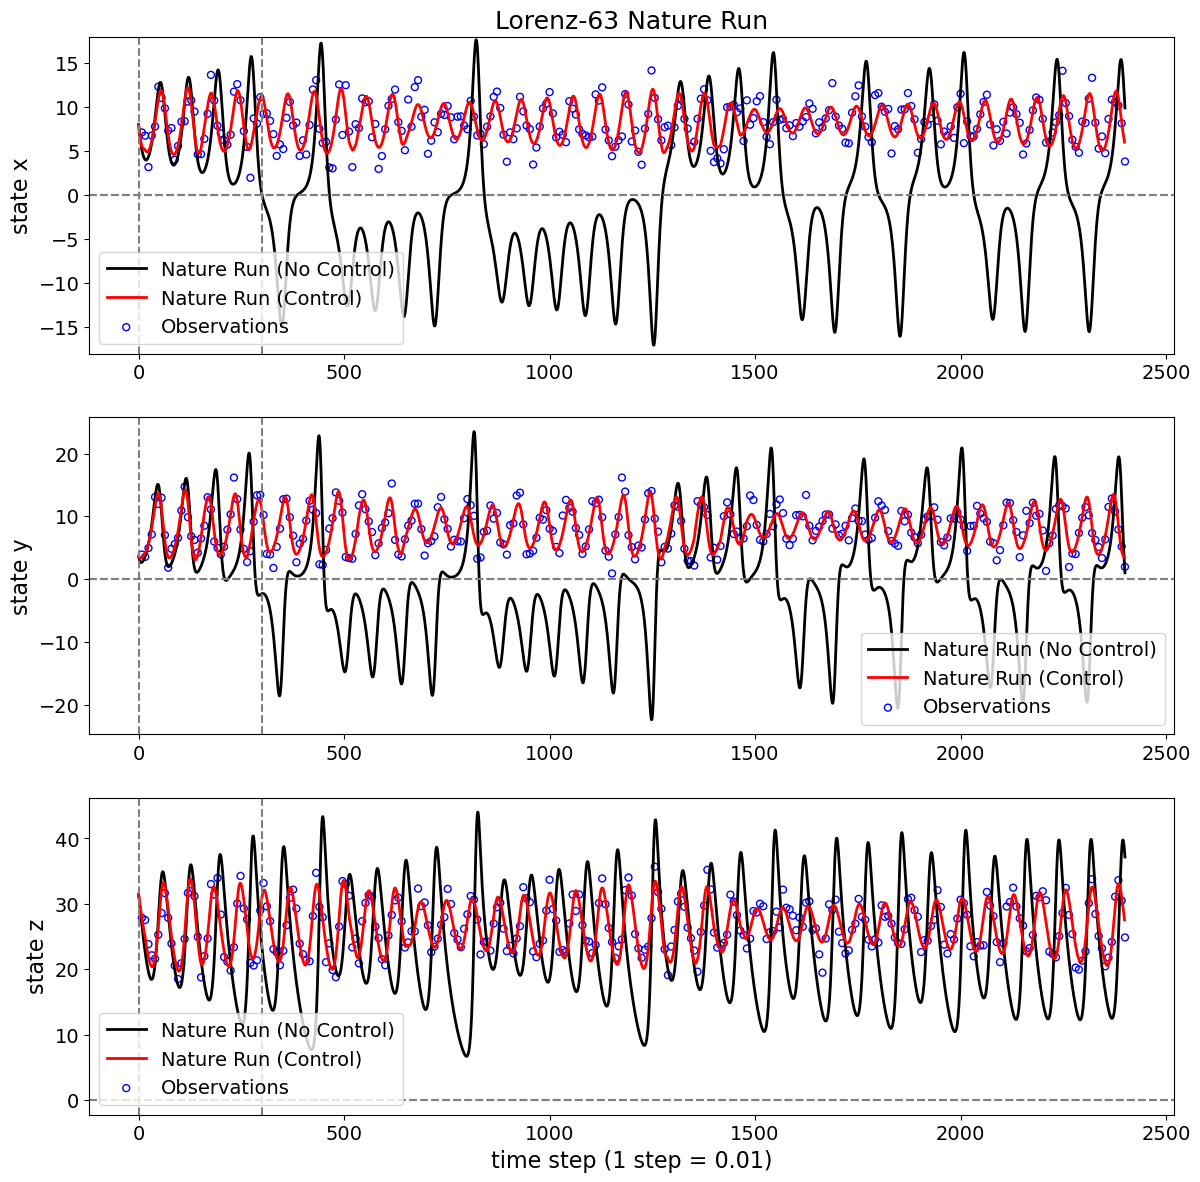

Plotting complete


In [205]:
fig = plt.figure(figsize = (14,14))
ax  = fig.add_subplot(311)
plt.plot(x_nature_nocontrol_3d[0,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,0], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.scatter(np.arange(Ta,Ta*num_cycles+Ta,Ta), yobs_new[:,0], marker='o', s=25, facecolors='none', edgecolors='blue', label="Observations")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
#for x in np.arange(8, 8*34, 8):
#	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
#plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state x', fontsize = 16)
plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-18,18)
#plt.xlim(-10,350)
ax.legend(fontsize=14)
#
ax  = fig.add_subplot(312)
plt.plot(x_nature_nocontrol_3d[1,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.scatter(np.arange(Ta,Ta*num_cycles+Ta,Ta), yobs_new[:,1], marker='o', s=25, facecolors='none', edgecolors='blue', label="Observations")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
#for x in np.arange(8, 8*34, 8):
#	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
#plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state y', fontsize = 16)
#plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
#plt.xlim(-10,20)
ax.legend(fontsize=14)
#
ax  = fig.add_subplot(313)
plt.plot(x_nature_nocontrol_3d[2,0:num_cycles*Ta+1], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'black', label="Nature Run (No Control)")
plt.plot(x_nature_control_3d[:,2], linestyle = 'solid', linewidth=2, marker='', markersize = 3, color = 'red', label="Nature Run (Control)")
plt.scatter(np.arange(Ta,Ta*num_cycles+Ta,Ta), yobs_new[:,2], marker='o', s=25, facecolors='none', edgecolors='blue', label="Observations")
plt.axhline(y = 0, linestyle='dashed', color = 'grey')   
plt.axhline(y = 0, linestyle='dashed', color = 'grey')
plt.axvline(x = 0, linestyle='dashed', color = 'grey')
#for x in np.arange(8, 8*34, 8):
#	plt.axvline(x=x, linestyle='dashed', linewidth=0.2, color='red')
plt.axvline(x = 300, linestyle='dashed', color = 'grey')
plt.xlabel('time step (1 step = 0.01)', fontsize = 16)
plt.ylabel('state z', fontsize = 16)
#plt.title('Lorenz-63 Nature Run', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-18,18)
#plt.xlim(-10,350)
ax.legend(fontsize=14)
plt.show()
#fig.savefig('NR_after_control.png', dpi=300, bbox_inches = 'tight')
plt.close(fig)
print('Plotting complete')

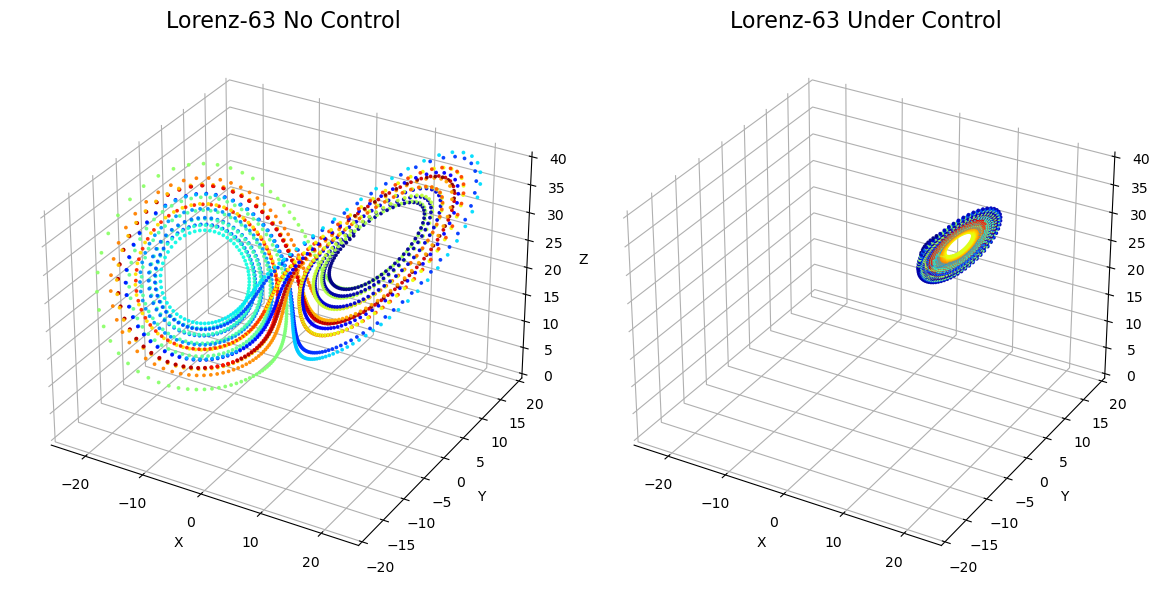

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(14, 6))

# === Plot 1: No-Control ===
ax1 = fig.add_subplot(121, projection='3d', facecolor='white')
ax1.scatter(
    x_nature_nocontrol_3d[0, 0:num_cycles*Ta+1],
    x_nature_nocontrol_3d[1, 0:num_cycles*Ta+1],
    x_nature_nocontrol_3d[2, 0:num_cycles*Ta+1],
    c=np.linspace(0, 1, len(x_nature_nocontrol_3d[0, 0:num_cycles*Ta+1])),
    cmap='jet',
    s=3,
    alpha = 0.9
)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Lorenz-63 No Control', fontsize=16, pad=1)
ax1.set_xlim(-25, 25)
ax1.set_ylim(-20, 20)
ax1.set_zlim(0, 40)
ax1.grid(alpha=0.3)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax1.set_axis_off()
#ax1.view_init(elev=30, azim=45)

# === Plot 2: Control ===
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    x_nature_control_3d[:, 0],
    x_nature_control_3d[:, 1],
    x_nature_control_3d[:, 2],
    c=np.linspace(0, 1, np.shape(x_nature_control_3d)[0]),
    cmap='jet',
    s=3,
    alpha = 0.9
)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Lorenz-63 Under Control', fontsize=16, pad=1)
ax2.set_xlim(-25, 25)
ax2.set_ylim(-20, 20)
ax2.set_zlim(0, 40)
ax2.grid(alpha=0.3)
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.tight_layout(rect=[0, 0, 0.98, 0.9])
#plt.subplots_adjust(left=0.05, right=0.6, bottom=0.05, top=0.55, wspace=0.15)
plt.subplots_adjust(wspace = -0.1)
plt.tight_layout()
plt.show()
#fig.savefig("Lorenz63_3D_UnderControl.png", facecolor='white', dpi=300)
fig.savefig("Lorenz63_3D_UnderControl.png", dpi=300, facecolor='white')



#### Plotting the evolution of the Lorenz attractor (Phase space):

solution shape: (2000, 3)


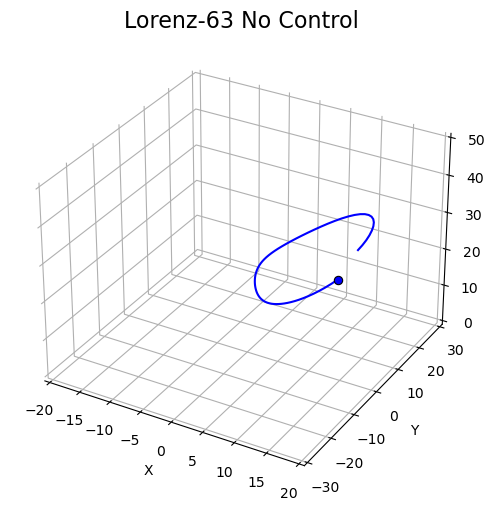

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Transpose to get shape (n_steps, 3)
solution         = x_nature_nocontrol_3d.copy().T[0:2000, :]
print("solution shape:", solution.shape)

# Time settings
t0 = 0.0
t_end = 80.0
dt = 0.01
t_points = np.arange(t0, t_end, dt)
n_steps = min(len(t_points), solution.shape[0])

# Create figure with two subplots
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(wspace=-0.1)

# Set common axis limits and labels
for ax in [ax1]:
    ax.set_xlim((-20, 20))
    ax.set_ylim((-30, 30))
    ax.set_zlim((0, 50))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax1.set_title('Lorenz-63 No Control', fontsize=16, pad=1)

# Line and point for each panel
line1, = ax1.plot([], [], [], lw = 1.5, color="blue")
point1, = ax1.plot([], [], [], 'o', color="blue", markeredgecolor='black', markeredgewidth = 0.8, markersize=6)

# Window size
window_size = 80

# Init function
def init():
    for line, point in [(line1, point1)]:
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
    return line1, point1, line2, point2

# Update function
def update(frame):
    start = max(0, frame - window_size)
    end = frame

    # Update first subplot
    line1.set_data(solution[start:end+1, 0], solution[start:end+1, 1])
    line1.set_3d_properties(solution[start:end+1, 2])
    point1.set_data([solution[end, 0]], [solution[end, 1]])
    point1.set_3d_properties([solution[end, 2]])


    return line1, point1

# Create and save animation
anim = FuncAnimation(fig, update, frames=range(0, n_steps, 4), init_func=init, blit=True)
anim.save("lorenz63_NR.gif", fps=20, writer="pillow")

plt.show()

solution shape: (80, 3)
solution shape: (80, 3)


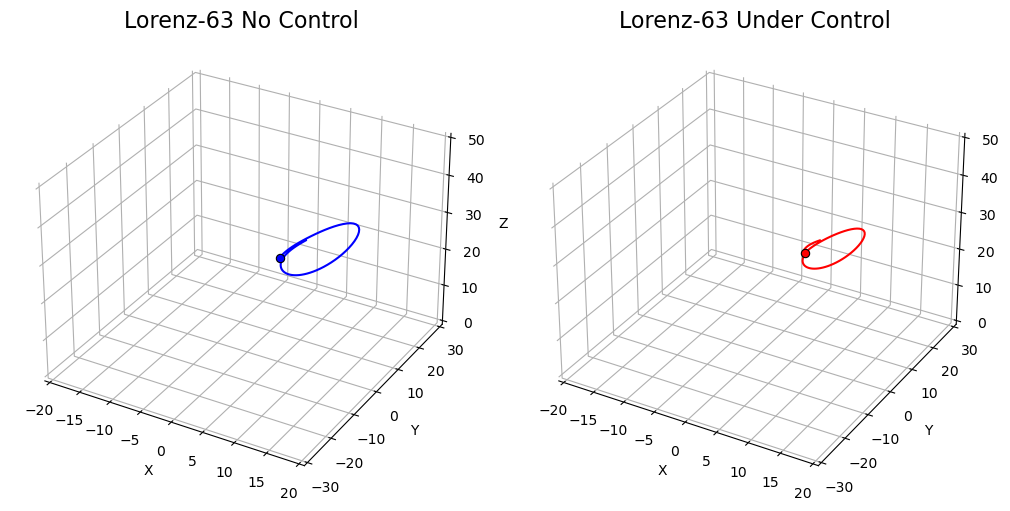

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Transpose to get shape (n_steps, 3)
solution         = x_nature_nocontrol_3d.copy().T[0:80, :]
solution_control = x_nature_control_3d.copy()[0:80, :]
print("solution shape:", solution.shape)
print("solution shape:", solution_control.shape)

# Time settings
t0 = 0.0
t_end = 80.0
dt = 0.01
t_points = np.arange(t0, t_end, dt)
n_steps = min(len(t_points), solution.shape[0])

# Create figure with two subplots
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plt.subplots_adjust(wspace=-0.1)
#plt.tight_layout()

# Set common axis limits and labels
for ax in [ax1, ax2]:
    ax.set_xlim((-20, 20))
    ax.set_ylim((-30, 30))
    ax.set_zlim((0, 50))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax1.set_title('Lorenz-63 No Control', fontsize=16, pad=1)
ax2.set_title('Lorenz-63 Under Control', fontsize=16, pad=1)

# Line and point for each panel
line1, = ax1.plot([], [], [], lw = 1.5, color="blue")
point1, = ax1.plot([], [], [], 'o', color="blue", markeredgecolor='black', markeredgewidth = 0.8, markersize=6)

line2, = ax2.plot([], [], [], lw = 1.5, color="red")
point2, = ax2.plot([], [], [], 'o', color="red", markeredgecolor='black', markeredgewidth = 0.8, markersize=6)

# Window size
window_size = 80

# Init function
def init():
    for line, point in [(line1, point1), (line2, point2)]:
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
    return line1, point1, line2, point2

# Update function
def update(frame):
    start = max(0, frame - window_size)
    end = frame

    # Update first subplot
    line1.set_data(solution[start:end+1, 0], solution[start:end+1, 1])
    line1.set_3d_properties(solution[start:end+1, 2])
    point1.set_data([solution[end, 0]], [solution[end, 1]])
    point1.set_3d_properties([solution[end, 2]])

    # Update second subplot (same data)
    line2.set_data(solution_control[start:end+1, 0], solution_control[start:end+1, 1])
    line2.set_3d_properties(solution_control[start:end+1, 2])
    point2.set_data([solution_control[end, 0]], [solution_control[end, 1]])
    point2.set_3d_properties([solution_control[end, 2]])

    return line1, point1, line2, point2

# Create and save animation
anim = FuncAnimation(fig, update, frames=range(0, n_steps, 4), init_func=init, blit=True)
anim.save("lorenz63_double.gif", fps=220, writer="pillow")

plt.show()


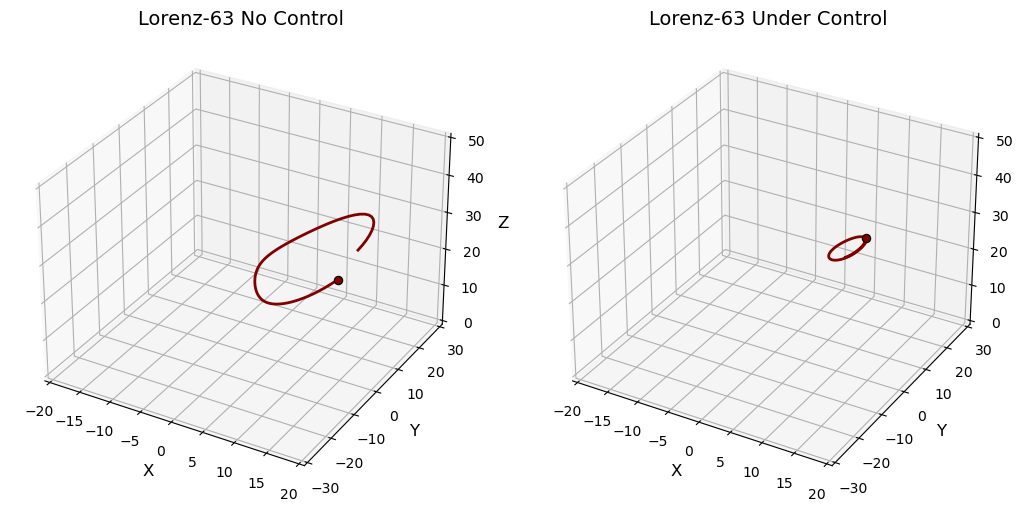

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.colors import Normalize

# Transpose and slice data
solution         = x_nature_nocontrol_3d.copy().T[0:2000, :]
solution_control = x_nature_control_3d.copy()[0:2000, :]

# Time setup
t0, t_end, dt = 0.0, 80.0, 0.01
t_points = np.arange(t0, t_end, dt)
n_steps = min(len(t_points), solution.shape[0])

# Normalize for color mapping
norm = Normalize(vmin=0, vmax=n_steps)
cmap = cm.get_cmap('jet')

# Create figure
fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plt.subplots_adjust(wspace=0.1)

# Shared axis limits
for ax in [ax1, ax2]:
    ax.set_xlim((-20, 20))
    ax.set_ylim((-30, 30))
    ax.set_zlim((0, 50))
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_zlabel("Z", fontsize=12)

ax1.set_title("Lorenz-63 No Control", fontsize=14)
ax2.set_title("Lorenz-63 Under Control", fontsize=14)

# Initialize lines/points
line1, = ax1.plot([], [], [], lw=2)
point1, = ax1.plot([], [], [], 'o', markeredgecolor='black', markeredgewidth = 0.8, markersize=6)

line2, = ax2.plot([], [], [], lw=2)
point2, = ax2.plot([], [], [], 'o', markeredgecolor='black', markeredgewidth = 0.8, markersize=6)

window_size = 80


def init():
    for line, point in [(line1, point1), (line2, point2)]:
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
    return line1, point1, line2, point2

def update(frame):
    start = max(0, frame - window_size)
    end = frame
    color = cmap(norm(end))

    # No-control plot
    line1.set_data(solution[start:end+1, 0], solution[start:end+1, 1])
    line1.set_3d_properties(solution[start:end+1, 2])
    line1.set_color(color)
    point1.set_data([solution[end, 0]], [solution[end, 1]])
    point1.set_3d_properties([solution[end, 2]])
    point1.set_color(color)

    # Control plot
    line2.set_data(solution_control[start:end+1, 0], solution_control[start:end+1, 1])
    line2.set_3d_properties(solution_control[start:end+1, 2])
    line2.set_color(color)
    point2.set_data([solution_control[end, 0]], [solution_control[end, 1]])
    point2.set_3d_properties([solution_control[end, 2]])
    point2.set_color(color)

    return line1, point1, line2, point2

# Create animation
anim = FuncAnimation(fig, update, frames=range(0, n_steps, 4), init_func=init, blit=True)

# Save or display
anim.save("lorenz63_double_colorful.gif", fps=20, writer="pillow")
plt.show()
